# Projet 3 : Préparez des données pour un organisme de santé publique

## Contexte

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts, qui est open source afin de permettre à tous de connaitre la qualité nutritionnelle des produits.

Aujourd'hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes.

L'agence Santé publique France confie à notre entreprise la création d'un système de suggestion ou d'auto-complétion pour aider les usagers à remplir plus efficacement la base de données, même si cette dernière venait à être légèrement modifiée.


Notre objectif : nettoyer et explorer les données en interne afin de déterminer la faisabilité de cette idée d'application.s. 

## Librairies utilisées avec le langage Python:

In [2]:
# Importation des librairies
import numpy as np
import pandas as pd
import pyarrow as pya
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

## Visualisation du tableau de données brutes


In [3]:
# Chargement des données brutes du fichier CSV avec des virgules pour séparateur
data=pd.read_csv('fr.openfoodfacts.org.products.csv', delimiter = '\t')
# Visualisation des 5 premières lignes
data.head(5)

code                                                url  \
0   3087  http://world-fr.openfoodfacts.org/produit/0000...   
1   4530  http://world-fr.openfoodfacts.org/produit/0000...   
2   4559  http://world-fr.openfoodfacts.org/produit/0000...   
3  16087  http://world-fr.openfoodfacts.org/produit/0000...   
4  16094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   
2          NaN      NaN  ...     NaN                         NaN   
3          NaN      NaN  ...     NaN                         NaN   
4          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                              NaN        NaN             NaN   
2                              NaN        NaN             NaN   
3                              NaN        NaN             NaN   
4                              NaN        NaN             NaN   

  carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
0                   NaN                     NaN                     NaN   
1                   NaN                    14.0                    14.0   
2                   NaN                     0.0                     0.0   
3                   NaN                    12.0                    12.0   
4                   NaN                     NaN                     NaN   

  glycemic-index_100g water-hardness_100g  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 162 columns]

Les champs sont séparés en quatre sections :

##### Les informations générales sur la fiche du produit :
- code : codebarre du produit ( EAN-13 ou  codes internes pour certains magasins). Pour les produits sans codebarres, Open Food Fact attribue un numéro commençant par le préfixe réservé 200.
- url : url de la page du produit sur Open Food Facts
- creator : contributeur qui a ajouté le produit pour la première fois
- created_t : date à laquelle le produit a été ajouté (timestamp)
- created_datetime : date à laquelle le produit a été ajouté (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
- last_modified_t : date à laquelle le produit a été modifié pour la dernière fois (timestamp)
- last_modified_datetime : date à laquelle le produit a été modifié pour la dernière fois (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
- product_name : nom du produit
- generic_name : nom générique
- quantity : quantité et unité

##### Un ensemble de tags (catégorie du produit, origine des ingrédients, liste des pays où il est vendu, ...)

##### Les ingrédients composants les produits et leurs additifs éventuels

##### Des informations nutritionnelles (quantité en gramme d'un nutriment pour 100 grammes du produit)

Pour plus d'informations sur les différentes variables : https://world.openfoodfacts.org/data/data-fields.txt

## Etude des données : nombre de lignes & colonnes, types des données et statistiques

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


Nous avons donc un data frame composé de 162 variables dont 106 sont des type flottant, et 56 de type objet.
Dans ce data frame, 320771 produits ont été entrés.

Interessons nous aux variables avec le plus de valeurs manquantes afin de trouver notre variable cible :

In [4]:
 # Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables et de filtrer sur les variables avec un pourcentage de valeurs manquantes supérieur à l'entrée percent

def show_miss_val(data,percent):  
    variables = []
    miss_val = []
    
    for item in data.columns:
        variables.append(item)
        miss_val.append(data[item].isna().mean())

    output = pd.DataFrame({
        'variable': variables, 
        'miss_val': miss_val 
    })    
        
    return output[output['miss_val']>=percent].sort_values('miss_val')

In [5]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable avec un filtre de 0.7 pour n'avoir que les colonnes avec plus de 70% de valeurs manquantes
data_vm=show_miss_val(data,0.7)
data_vm.head(120)

variable  miss_val
55         pnns_groups_2  0.705426
54         pnns_groups_1  0.714710
16         categories_fr  0.736850
14            categories  0.736854
15       categories_tags  0.736919
..                   ...       ...
94     elaidic-acid_100g  1.000000
98    nervonic-acid_100g  1.000000
97      erucic-acid_100g  1.000000
52    nutrition_grade_uk  1.000000
161  water-hardness_100g  1.000000

[119 rows x 2 columns]

In [6]:
data['pnns_groups_1'].describe()

count       91513
unique         14
top       unknown
freq        22624
Name: pnns_groups_1, dtype: object

In [7]:
data['pnns_groups_1'].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'fruits-and-vegetables',
       'Milk and dairy products', 'Salty snacks', 'sugary-snacks',
       'cereals-and-potatoes', 'salty-snacks'], dtype=object)

La variable 'pnns_groups_1' parait être une bonne variable cible avec 71.5% de valeurs manquantes et seulement 14 valeurs possibles.

## Nettoyage du dataframe

Nous pouvons par contre remarquer que certaines valeurs sont les mêmes et que seules la typographie change. Remédions à cela :

In [4]:
def pnnsgroup1_imputation (data) :
    compt=0
    for item in data['pnns_groups_1'] :
        if item=='salty-snacks' : data.loc[compt,'pnns_groups_1']= 'Salty snacks'
        if item=='cereals-and-potatoes' : data.loc[compt,'pnns_groups_1']= 'Cereals and potatoes'
        if item=='sugary-snacks' : data.loc[compt,'pnns_groups_1']= 'Sugary snacks'
        if item=='fruits-and-vegetables' : data.loc[compt,'pnns_groups_1']= 'Fruits and vegetables'
        compt+=1
    return data

In [6]:
data_1 = pnnsgroup1_imputation (data)
data_1['pnns_groups_1'].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'Milk and dairy products',
       'Salty snacks'], dtype=object)

Nous avons donc maintenant 10 valeurs possibles pour notre variable cible. 

Supprimons ensuite les lignes qui n'ont pas de valeurs pour la variable cible :

In [7]:
#  Fonction supprimant les lignes produits qui ont une valeur manquante pour la variable cible
def supp_nan_cible (data) :
    valeur=['unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'Milk and dairy products',
       'Salty snacks']
# Cast de la variable cible comme objet
    data_1['pnns_groups_1']=data['pnns_groups_1'].astype(object)
# Imputation à NaN de toutes les valeurs de 'pnns_groups_1' différentes de celles attendues
    data_1.loc[~data_1['pnns_groups_1'].isin(valeur)]='NaN'
# Suppression des lignes à 'NaN'
    data_1.drop(data_1[data_1['pnns_groups_1'] == 'NaN'].index, inplace=True)
    return data_1

data_2=supp_nan_cible(data_1)
data_pnns_1 =data_2.groupby('pnns_groups_1', dropna=False)['code'].count()
print(data_pnns_1)

pnns_groups_1
Beverages                   9033
Cereals and potatoes        8458
Composite foods             6747
Fat and sauces              5216
Fish Meat Eggs              8041
Fruits and vegetables       6895
Milk and dairy products     8825
Salty snacks                2810
Sugary snacks              12864
unknown                    22624
Name: code, dtype: int64


In [11]:
data_2.shape

(91513, 162)

Il reste 91513 lignes de produits pour poursuivre notre analyse. 

Cherchons maintenant à conserver des variables avec peu de valeurs manquantes et pertinentes pour prédire notre variable cible :

In [12]:
data_vm=show_miss_val(data_2,0)
data_vm.head(50)

variable  miss_val
0                                       code  0.000000
54                             pnns_groups_1  0.000000
55                             pnns_groups_2  0.000000
56                                    states  0.000000
57                               states_tags  0.000000
6                     last_modified_datetime  0.000000
58                                 states_fr  0.000000
3                                  created_t  0.000000
1                                        url  0.000000
5                            last_modified_t  0.000000
4                           created_datetime  0.000011
2                                    creator  0.000022
31                                 countries  0.001661
33                              countries_fr  0.001661
32                            countries_tags  0.001661
7                               product_name  0.032946
12                                    brands  0.041721
13                               brands_tags  0.041754
9                                   quantity  0.110181
60                          main_category_fr  0.110640
59                             main_category  0.110640
15                           categories_tags  0.110640
14                                categories  0.110640
16                             categories_fr  0.110640
11                            packaging_tags  0.194726
10                                 packaging  0.194759
34                          ingredients_text  0.232885
46               ingredients_from_palm_oil_n  0.232885
49   ingredients_that_may_be_from_palm_oil_n  0.232885
42                               additives_n  0.232885
43                                 additives  0.233202
63                               energy_100g  0.259001
112                            proteins_100g  0.266279
65                                  fat_100g  0.296439
101                       carbohydrates_100g  0.301345
116                                salt_100g  0.302055
117                              sodium_100g  0.302143
102                              sugars_100g  0.304929
66                        saturated-fat_100g  0.308262
62                           image_small_url  0.308754
61                                 image_url  0.308754
53                        nutrition_grade_fr  0.324642
159                  nutrition-score-uk_100g  0.324642
158                  nutrition-score-fr_100g  0.324642
29                           purchase_places  0.386065
8                               generic_name  0.439446
30                                    stores  0.452154
23                                 labels_fr  0.539169
22                               labels_tags  0.539169
21                                    labels  0.540109

Voici les variables qu'il semble pertinent de garder pour notre analyse et la prédiction de notre variable cible : pnns_groups_1, pnns_groups_2, product_name, main_category_fr, energy_100g, proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,sugars_100g,saturated-fat_100g,nutrition_grade_fr, nutrition-score-fr_100g	

In [8]:
#  Fonction permettant de ne garder que les variables d'intérêt définies au préalable
def sel_var_interet (data) :
    variable =['pnns_groups_1', 'pnns_groups_2', 'product_name', 'main_category_fr', 'energy_100g', 'proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g',
               'sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g','nutrition_grade_fr', 'nutrition-score-fr_100g']
    del_var=[]
    for var in data.columns :
        if var not in variable : del_var.append(var)
    data=data.drop(del_var,axis=1)
    return data
    

In [14]:
data_3 = sel_var_interet(data_2)

In [15]:
data_3.head()

product_name nutrition_grade_fr          pnns_groups_1 pnns_groups_2  \
46    Filet de bœuf                NaN                unknown       unknown   
106  Lion Peanut x2                  e                unknown       unknown   
136         Twix x2                NaN                unknown       unknown   
138  Pack de 2 Twix                NaN                unknown       unknown   
174    Salade Cesar                  c  Fruits and vegetables    Vegetables   

    main_category_fr energy_100g fat_100g saturated-fat_100g  \
46    Filet-de-boeuf         NaN      NaN                NaN   
106              NaN      1883.0     20.0               12.5   
136              NaN         NaN      NaN                NaN   
138              NaN      1481.0     4.17                NaN   
174    Légumes frais      1210.0     12.0                7.0   

    monounsaturated-fat_100g polyunsaturated-fat_100g trans-fat_100g  \
46                       NaN                      NaN            NaN   
106                      NaN                      NaN            NaN   
136                      NaN                      NaN            NaN   
138                      NaN                      NaN            NaN   
174                      NaN                      NaN            NaN   

    carbohydrates_100g sugars_100g proteins_100g salt_100g sodium_100g  \
46                 NaN         NaN           NaN       NaN         NaN   
106               70.0        57.5           2.5   0.09652       0.038   
136                NaN         NaN           NaN       NaN         NaN   
138              77.08         NaN          6.25       NaN         NaN   
174               23.0         0.0          22.0      2.16        0.85   

    nutrition-score-fr_100g  
46                      NaN  
106                    22.0  
136                     NaN  
138                     NaN  
174                     6.0

Recherchons maintenant les doublons. Nous considèrerons que les doublons sont les lignes identiques pour la totalité des 17 variables d'intérêt choisies.

In [16]:
data_3.duplicated(subset=['pnns_groups_1', 'pnns_groups_2', 'product_name', 'main_category_fr', 'energy_100g', 'proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g',
               'sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g','nutrition_grade_fr', 'nutrition-score-fr_100g']).sum()


5246

Il existe 5246 duplicatas. Supprimons les :

In [17]:
data_4 = data_3.drop_duplicates()
data_4.shape

(86267, 17)

Il nous reste un dataframe de 86267 lignes ou produits avec 17 variables pour notre analyse. Regardons le de plus près :

In [18]:
data_4.dtypes

product_name                object
nutrition_grade_fr          object
pnns_groups_1               object
pnns_groups_2               object
main_category_fr            object
energy_100g                 object
fat_100g                    object
saturated-fat_100g          object
monounsaturated-fat_100g    object
polyunsaturated-fat_100g    object
trans-fat_100g              object
carbohydrates_100g          object
sugars_100g                 object
proteins_100g               object
salt_100g                   object
sodium_100g                 object
nutrition-score-fr_100g     object
dtype: object

Castons les variables finissant par _100g comme flottant puisque ce sont des variables quantitatives :

In [19]:
data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g']]=data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g']].apply(pd.to_numeric)


C:\Users\celine.lesur\AppData\Local\Temp\ipykernel_27364\1191674275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g']]=data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g']].apply(pd.to_numeric)


In [20]:
data_4.dtypes

product_name                 object
nutrition_grade_fr           object
pnns_groups_1                object
pnns_groups_2                object
main_category_fr             object
energy_100g                 float64
fat_100g                    float64
saturated-fat_100g          float64
monounsaturated-fat_100g    float64
polyunsaturated-fat_100g    float64
trans-fat_100g              float64
carbohydrates_100g          float64
sugars_100g                 float64
proteins_100g               float64
salt_100g                   float64
sodium_100g                 float64
nutrition-score-fr_100g     float64
dtype: object

In [21]:
#  Variables quantitatives :
data_4.describe()

energy_100g      fat_100g  saturated-fat_100g  \
count  6.669300e+04  63275.000000        62258.000000   
mean   1.151365e+03     13.419000            5.340947   
std    1.263336e+04     17.199055            8.280426   
min    0.000000e+00      0.000000            0.000000   
25%    3.940000e+02      1.100000            0.300000   
50%    1.010000e+03      6.600000            1.900000   
75%    1.644000e+03     21.100000            7.400000   
max    3.251373e+06    380.000000          210.000000   

       monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
count               2107.000000               2131.000000      1865.00000   
mean                  15.508837                  8.357169         0.11624   
std                   20.011566                 13.127432         1.00085   
min                    0.000000                  0.000000         0.00000   
25%                    1.800000                  1.200000         0.00000   
50%                    7.140000                  3.100000         0.00000   
75%                   22.000000                  9.000000         0.00000   
max                   82.000000                 75.000000        30.30000   

       carbohydrates_100g   sugars_100g  proteins_100g     salt_100g  \
count        62829.000000  62557.000000   66033.000000  62814.000000   
mean            27.959923     13.220373       7.501633      1.153939   
std             27.403685     18.805312       7.612156      4.869554   
min              0.000000     -0.100000       0.000000      0.000000   
25%              4.400000      1.000000       1.670000      0.070000   
50%             14.800000      4.170000       5.800000      0.508000   
75%             53.300000     17.000000      10.300000      1.200000   
max            190.000000    134.000000     100.000000    297.600000   

        sodium_100g  nutrition-score-fr_100g  
count  62806.000000             60766.000000  
mean       0.454356                 8.434421  
std        1.917114                 9.104743  
min        0.000000               -15.000000  
25%        0.027559                 1.000000  
50%        0.200000                 8.000000  
75%        0.472441                15.000000  
max      117.165354                40.000000

In [22]:
#  Variables qualitatives :
data_4.describe(exclude=[np.number])

product_name nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
count         85309              60766         86267         86267   
unique        72123                  5            10            40   
top          Orange                  d       unknown       unknown   
freq             43              16578         20116         20116   

       main_category_fr  
count             78023  
unique             3543  
top            Boissons  
freq               3031

Nous pouvons observer des valeurs aberrantes pour les variables quantitatives. Toutes les variables qui finissent par '_100g' sont exprimés en g (excepté pour l'energie, en KJ, et le nutriscore) et ne peuvent donc pas dépasser 100g dans 100g de produit. Les valeurs de ces variables ne peuvent pas non plus être négatives.

Excepté pour l'energie et le nutriscore, imputons en Nan toutes les valeurs négatives ou supérieures à 100 pour les variables finissant par '_100g'.

Concernant l'énergie, après des recherches, il semblerait que l'énergie maximum en kJ pour 100g est d'environ 3800kJ. Il semble pertinent d'imputer en Nan les valeurs de cette variable qui sont supérieures à 4000kJ.

In [9]:
# Fonction permettant de ne garder que les variables quantitatives du Dataframe
def col_quant (data) :
    del_var=[]
    variables = data.columns
    for item in variables :
        if data[item].dtypes == 'object' :
            del_var.append(item)
    output = data.drop(columns=del_var, axis = 1)
    return output

# Imputation des valeur aberrantes en Nan
def imput_nan_imp_values_100gcol(data) :
    variables = ['energy_100g','energy-kj_100g','energy-kcal_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
    data_quant=col_quant(data)
    df=data_quant.columns
    for item in df :
        if item =='energy_100g' :
            data.loc[(data[item]>4000), item]= np.nan
        elif item not in variables :
            data.loc[(data[item]<0) |(data[item]>100), item]= np.nan
        else : pass
    return data

In [10]:
data_clean=imput_nan_imp_values_100gcol(data_4)

# Nouvelles statistiques des colonnes quantitatives sans les valeurs aberrantes
data_clean.describe()

NameError: name 'data_4' is not defined

Pour un souci de facilité, automatisons cette première étape de nettoyage avant d'approfondir l'analyse :

In [11]:
#  Fonction automatisant le nettoyage du dataframe en utilisant les fonctions développées précédemment
def nettoyage_df (data) :
    data_1 = pnnsgroup1_imputation (data)
    data_2=supp_nan_cible(data_1)
    data_3 = sel_var_interet(data_2)
    data_4 = data_3.drop_duplicates(ignore_index=True)
    data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g']]=data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g']].apply(pd.to_numeric)
    data_clean=imput_nan_imp_values_100gcol(data_4)
    return data_clean

In [12]:
data_clean = nettoyage_df(data)
data_clean.describe()

energy_100g      fat_100g  saturated-fat_100g  \
count  66663.000000  63272.000000        62257.000000   
mean    1096.380585     13.410375            5.337659   
std      782.907680     17.130200            8.239767   
min        0.000000      0.000000            0.000000   
25%      393.000000      1.100000            0.300000   
50%     1009.000000      6.600000            1.900000   
75%     1644.000000     21.100000            7.400000   
max     4000.000000    100.000000          100.000000   

       monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
count               2107.000000               2131.000000      1865.00000   
mean                  15.508837                  8.357169         0.11624   
std                   20.011566                 13.127432         1.00085   
min                    0.000000                  0.000000         0.00000   
25%                    1.800000                  1.200000         0.00000   
50%                    7.140000                  3.100000         0.00000   
75%                   22.000000                  9.000000         0.00000   
max                   82.000000                 75.000000        30.30000   

       carbohydrates_100g   sugars_100g  proteins_100g     salt_100g  \
count        62816.000000  62548.000000   66033.000000  62805.000000   
mean            27.940584     13.208571       7.501633      1.130245   
std             27.370737     18.776197       7.612156      4.364655   
min              0.000000      0.000000       0.000000      0.000000   
25%              4.400000      1.000000       1.670000      0.070000   
50%             14.755000      4.120000       5.800000      0.508000   
75%             53.300000     17.000000      10.300000      1.200000   
max            100.000000    100.000000     100.000000    100.000000   

        sodium_100g  nutrition-score-fr_100g  
count  62804.000000             60766.000000  
mean       0.450769                 8.434421  
std        1.808573                 9.104743  
min        0.000000               -15.000000  
25%        0.027559                 1.000000  
50%        0.200000                 8.000000  
75%        0.472441                15.000000  
max       83.000000                40.000000

In [13]:
data_clean.describe(exclude=[np.number])

product_name nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
count         85309              60766         86267         86267   
unique        72123                  5            10            40   
top          Orange                  d       unknown       unknown   
freq             43              16578         20116         20116   

       main_category_fr  
count             78023  
unique             3543  
top            Boissons  
freq               3031

In [167]:
data_clean.shape

(86267, 17)

## Analyses et visualisations

Regardons la distribution des variables catégorielles :

<Axes: title={'center': 'Répartition du nutriscore dans notre dataframe nettoyé.'}, xlabel='nutrition_grade_fr', ylabel='count'>

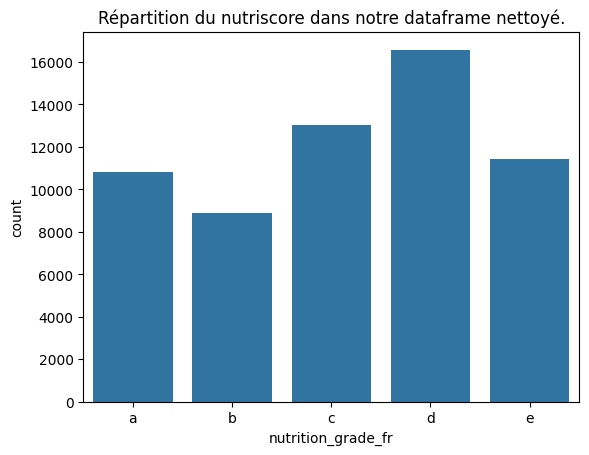

In [40]:
plt.title(f'Répartition du nutriscore dans notre dataframe nettoyé.')
sns.countplot(data_clean, x="nutrition_grade_fr", order=['a','b','c','d','e'])

In [168]:
# Calcul de la répartition du nutriscore
data_nutri =data_clean.groupby('nutrition_grade_fr', dropna=False)['pnns_groups_1'].count()
print(data_nutri)

nutrition_grade_fr
a      10829
b       8880
c      13044
d      16578
e      11435
NaN    25501
Name: pnns_groups_1, dtype: int64


Text(0.5, 1.0, 'Proportion des nutriscores')

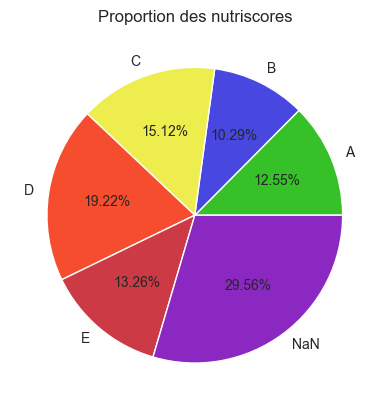

In [173]:
labels = ['A', 'B', 'C', 'D', 'E','NaN']
colors = ['#36c128','#4848E1','#EDED4E','#F64D2F','#CC3B45','#8b28c1']
sns.set_style("darkgrid")
# Affichage d'un diagramme circulaire pour visualiser la proportion des nutriscores dans notre base de données
plt.pie(x=data_nutri, labels=labels, colors=colors,autopct='%.2f%%')
plt.title("Proportion des nutriscores")

Il y a un nombre non négligeable (presque 30%) de valeurs de nutrigrade manquants. Regardons si un nutriscore est renseigné afin de pouvoir l'imputer :

In [172]:
nutriscore_mv=data_clean.loc[(data_clean['nutrition-score-fr_100g'].isna()==False) & (data_clean['nutrition_grade_fr']=='Nan')]
nutriscore_mv.shape

(0, 17)

In [ ]:
Aucun nutriscore n'est renseigné pour un nutrigrade manquant. L'imputation n'est donc pas évidente.

In [105]:
# Création d'une liste ordonné de 'pnns_groups_1' en fonction du plus grand nombre de nutriscore 'a'
nutriscore_order = data_clean.groupby('pnns_groups_1',as_index=False)['nutrition_grade_fr'].value_counts()
nutriscore_order=nutriscore_order.loc[(nutriscore_order['nutrition_grade_fr']=='a'), ['pnns_groups_1','count']]
nutriscore_order=nutriscore_order.sort_values(by="count", ascending=False)

<Axes: title={'center': 'Nombre de produits par catégorie et nutriscore'}, xlabel='count', ylabel='pnns_groups_1'>

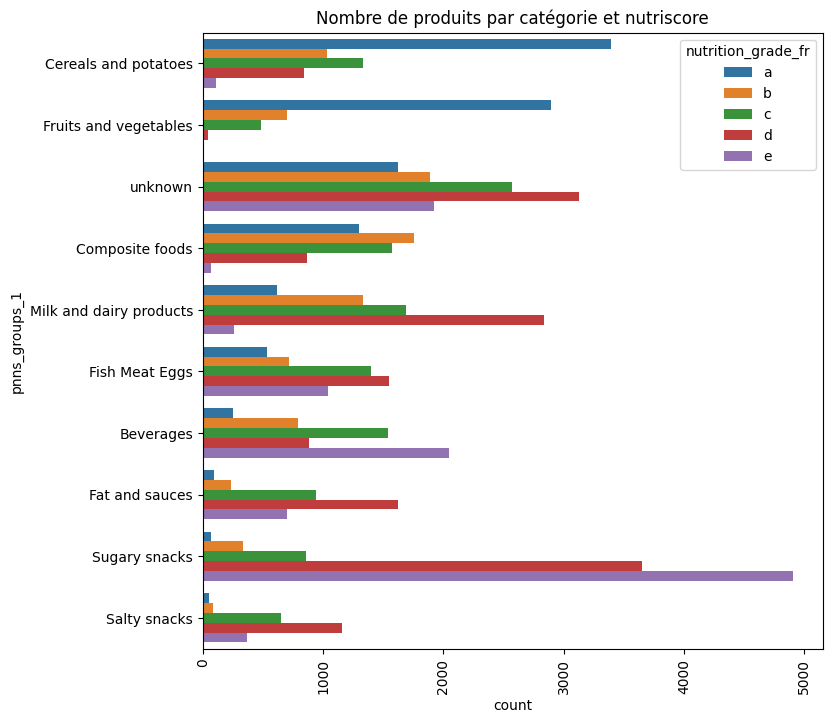

In [106]:
plt.figure(figsize=(8, 8))
plt.xticks(rotation = 'vertical')
plt.title(f'Nombre de produits par catégorie et nutriscore')
sns.countplot(data_clean, y="pnns_groups_1",hue="nutrition_grade_fr",hue_order=['a','b','c','d','e'], order=nutriscore_order['pnns_groups_1'])

Sans surprise, on aperçoit que les catégories avec le moins de produits avec de bons nutriscores sont les catégories salées, sucrées, graisses,...

Passons aux variables quantitatives :

(on affichera pas les valeurs atypiques sur les boîtes à moustaches car les distributions des variables ne sont pas normales et donc la méthode interquartile n'est pas pertinente pour détecter les valeurs atypiques)

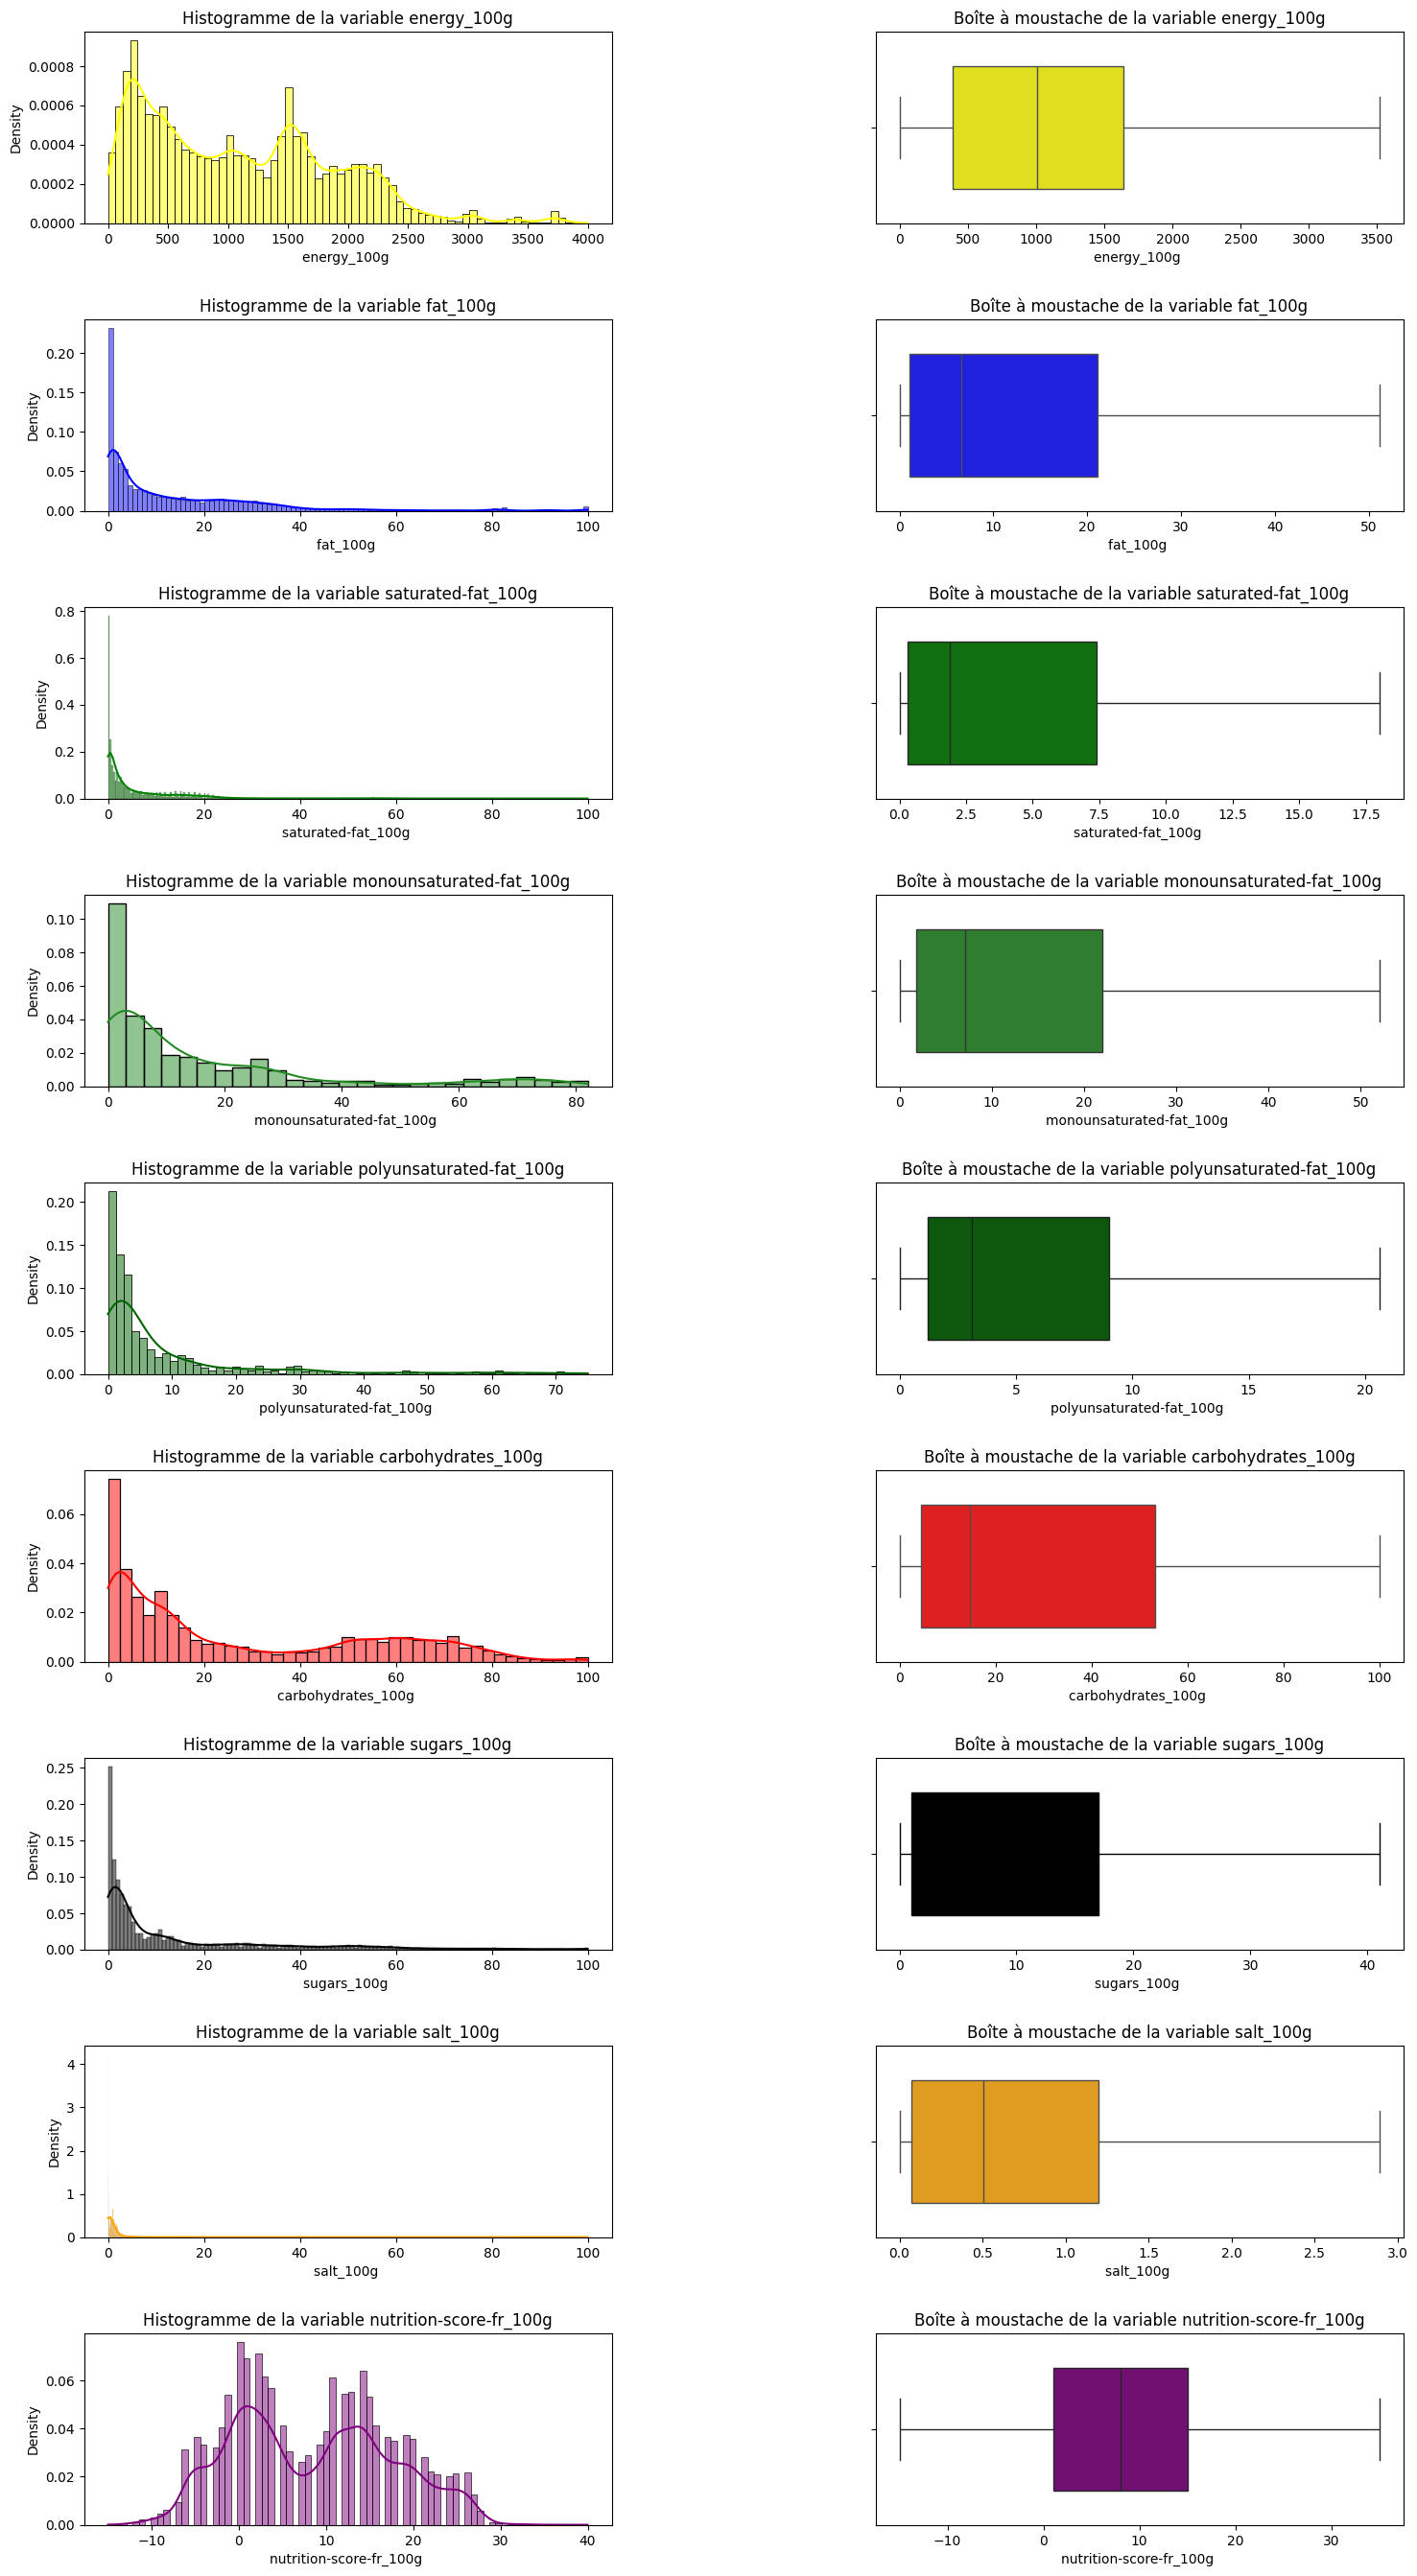

In [111]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',3),('saturated-fat_100g','green',5),('monounsaturated-fat_100g','forestgreen',7),('polyunsaturated-fat_100g','darkgreen',9),('carbohydrates_100g','red',11),('sugars_100g','black',13),('salt_100g','orange',15),('nutrition-score-fr_100g','purple',17)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 20))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(9, 2, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density")
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")

    place=place+1
    # Création des boîtes à moustaches
    axes = figure.add_subplot(9, 2, place)
    sns.boxplot(data=data_clean,x=variable, ax=axes,gap=0.2,legend=False, color=color, showfliers=False)
    plt.title(f'Boîte à moustache de la variable {variable}')
    plt.xlabel(f"{variable} ")


Visualisons les également à l'échelle logarithmique pour mieux visualiser la distribution :

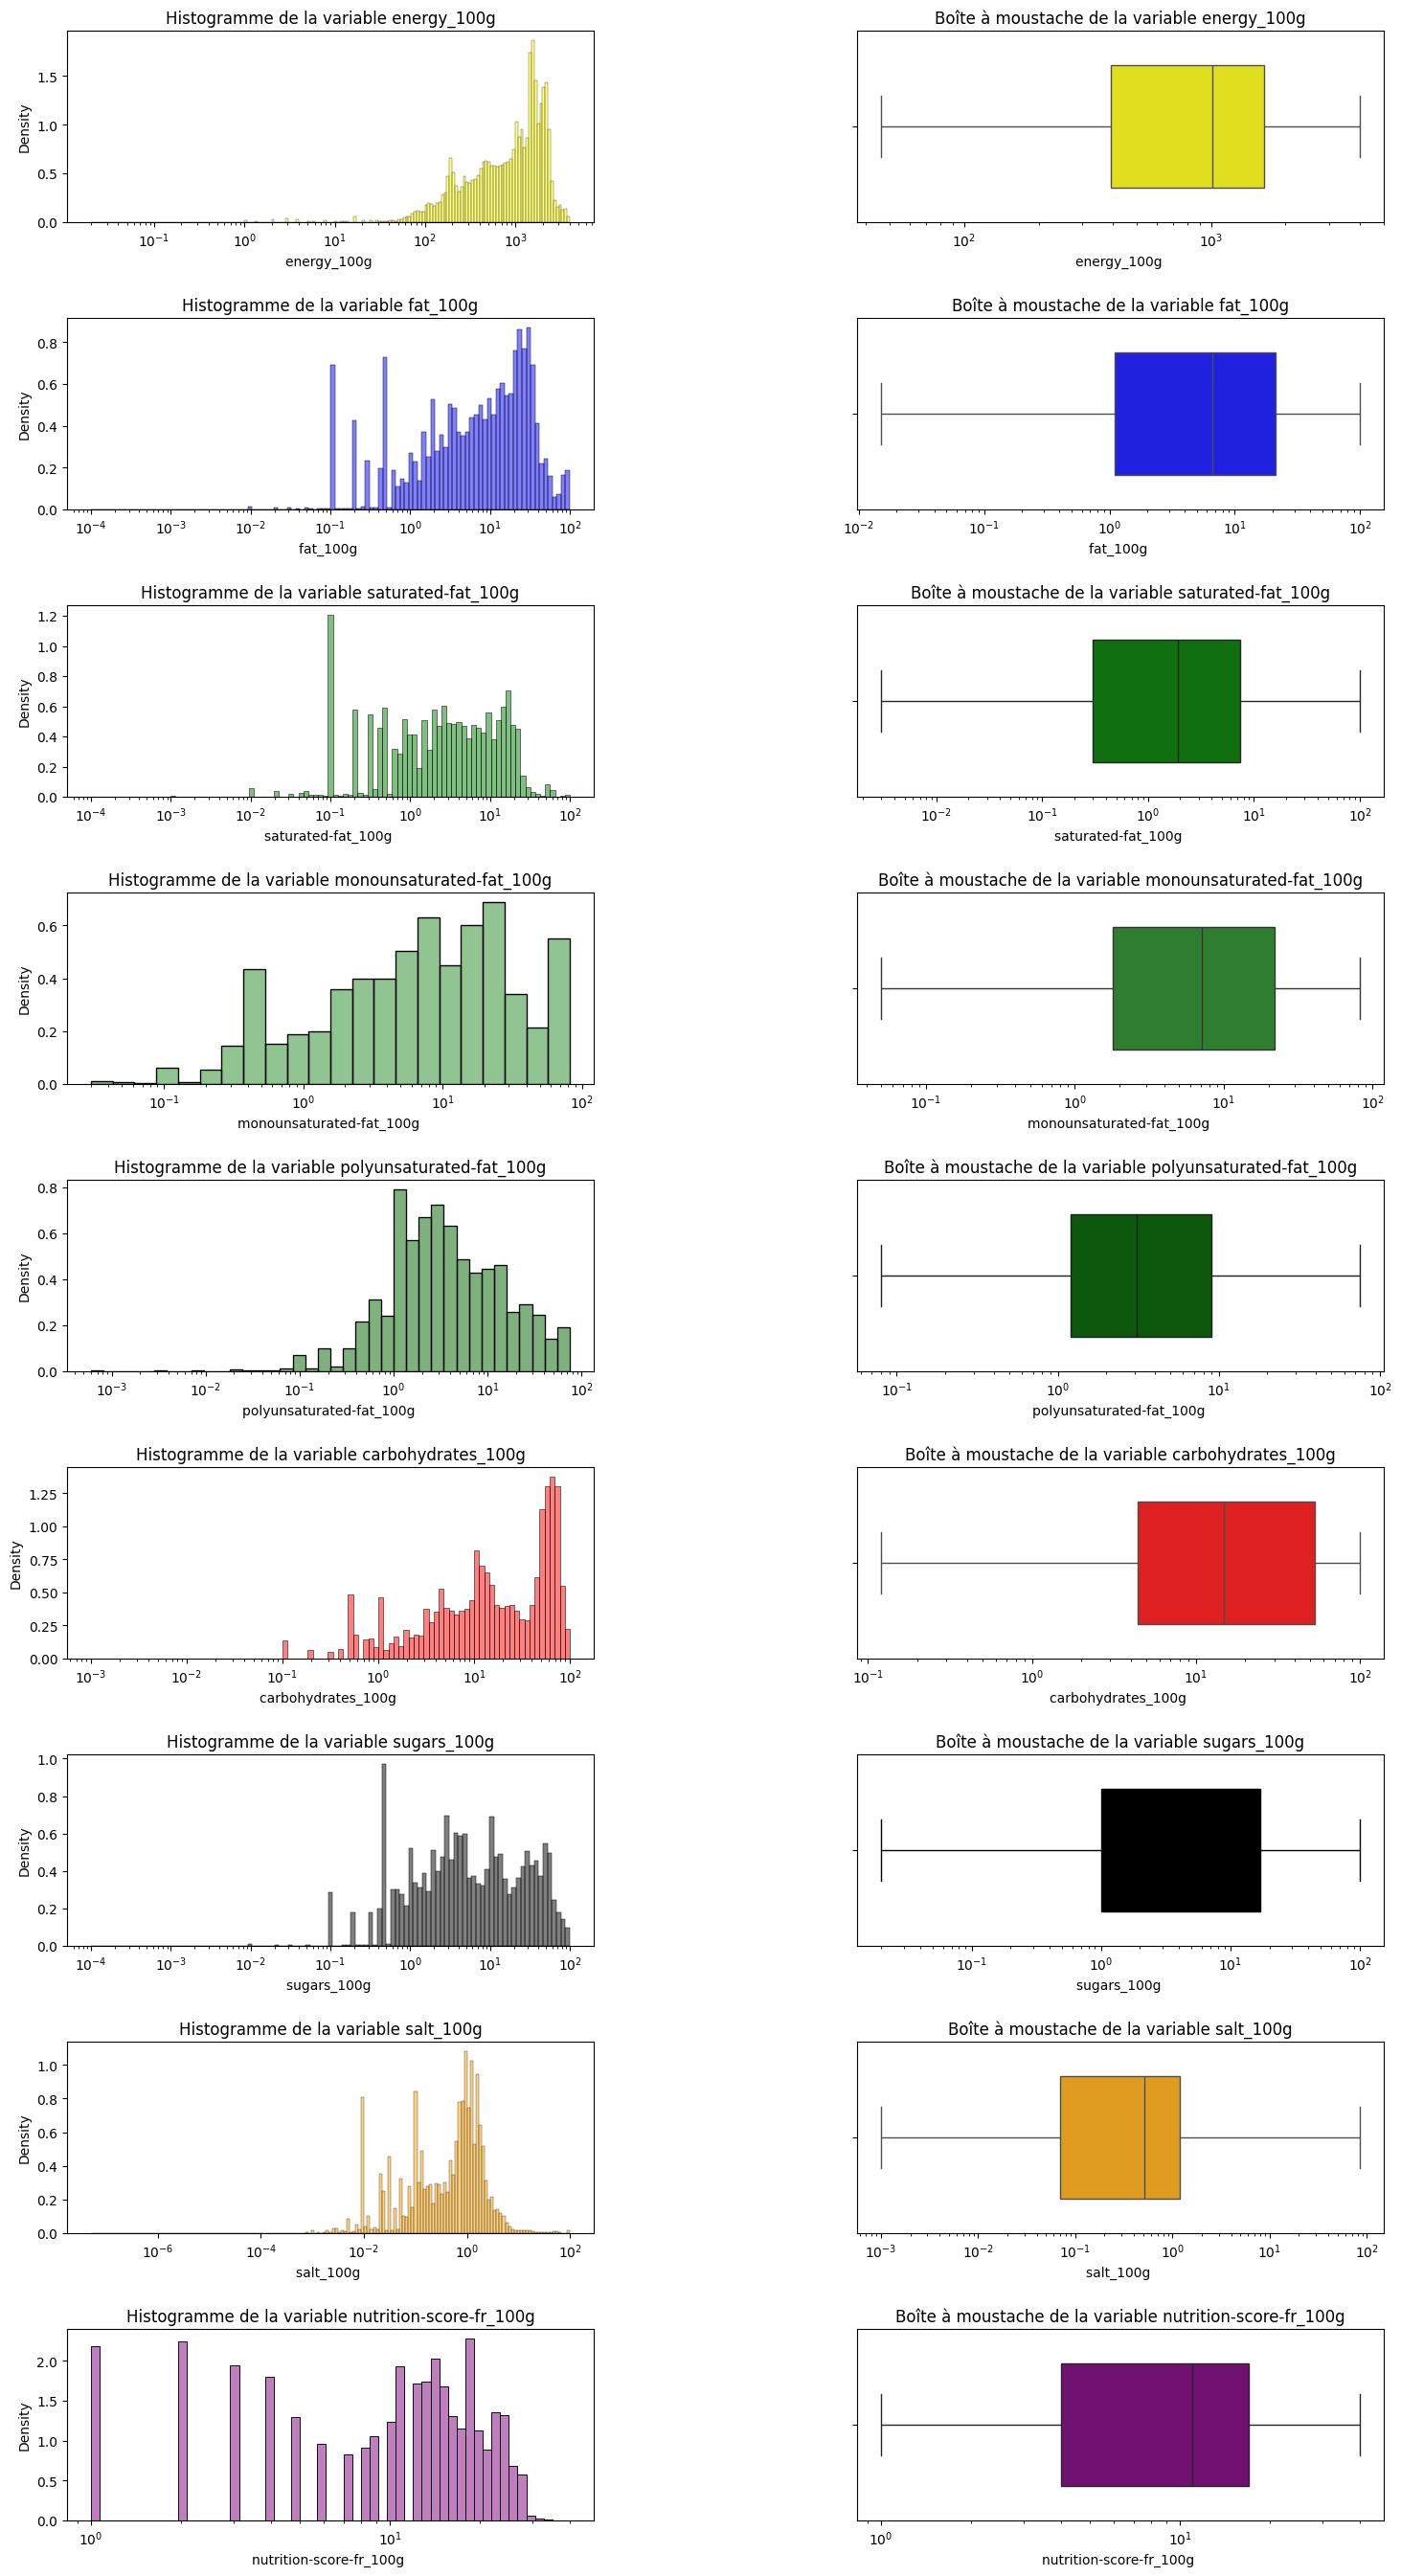

In [124]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',3),('saturated-fat_100g','green',5),('monounsaturated-fat_100g','forestgreen',7),('polyunsaturated-fat_100g','darkgreen',9),('carbohydrates_100g','red',11),('sugars_100g','black',13),('salt_100g','orange',15),('nutrition-score-fr_100g','purple',17)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 20))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(9, 2, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")

    place=place+1
    # Création des boîtes à moustaches
    axes = figure.add_subplot(9, 2, place)
    sns.boxplot(data=data_clean,x=variable, ax=axes,gap=0.2,legend=False, color=color, showfliers=False, log_scale=True)
    plt.title(f'Boîte à moustache de la variable {variable}')
    plt.xlabel(f"{variable} ")


Passons à des analyses bivariées sur ces données et construisons maintenant la matrice de corrélations pour définir des relations entre les variables :

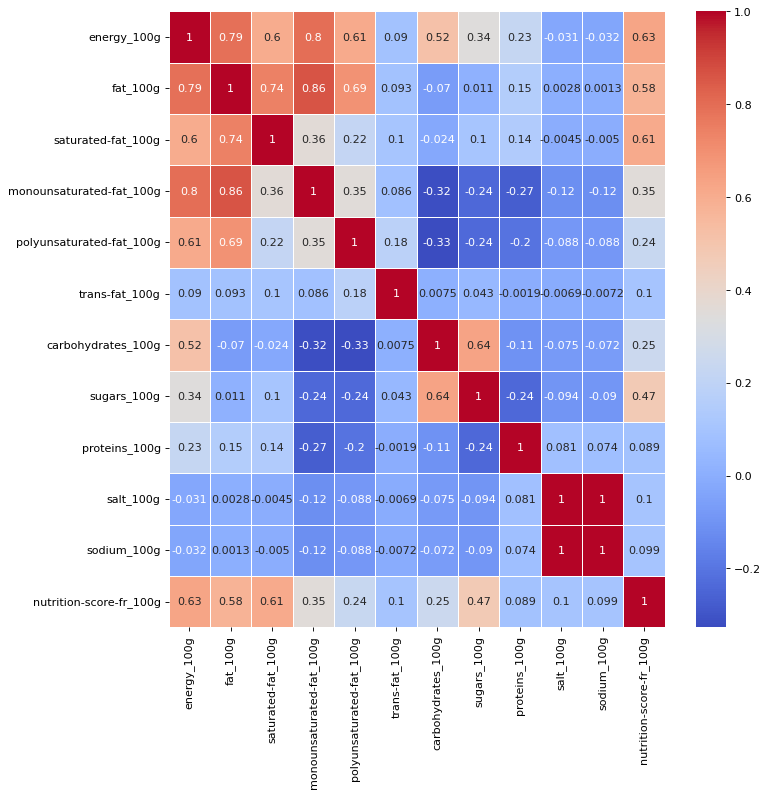

In [27]:
data_quant=col_quant(data_clean)
corr=data_quant.corr()
fig = plt.figure(figsize=(10,10), dpi = 80)
sns.heatmap(corr,cmap='coolwarm',annot=True,linewidth=0.9)
plt.show()

Nous observons :
 - une corrélation parfaite entre le sel et le sodium qui était attendue, l'analyse d'une seule de ces variables sera pertinente
 - les graisses sont fortement corrélées entre elles (excepté la trans-fat) et également corrélées au nutriscore et à l'énergie
 - le sucre et les carbohydrates sont fortement corrélés entre eux
 - le sucre est légèrement corrélé au nutriscore et les carbohydrates à l'énergie
 - Aucune anti-corrélation prononcée n'apparait

Si nous nous concentrons uniquement sur ces variables :

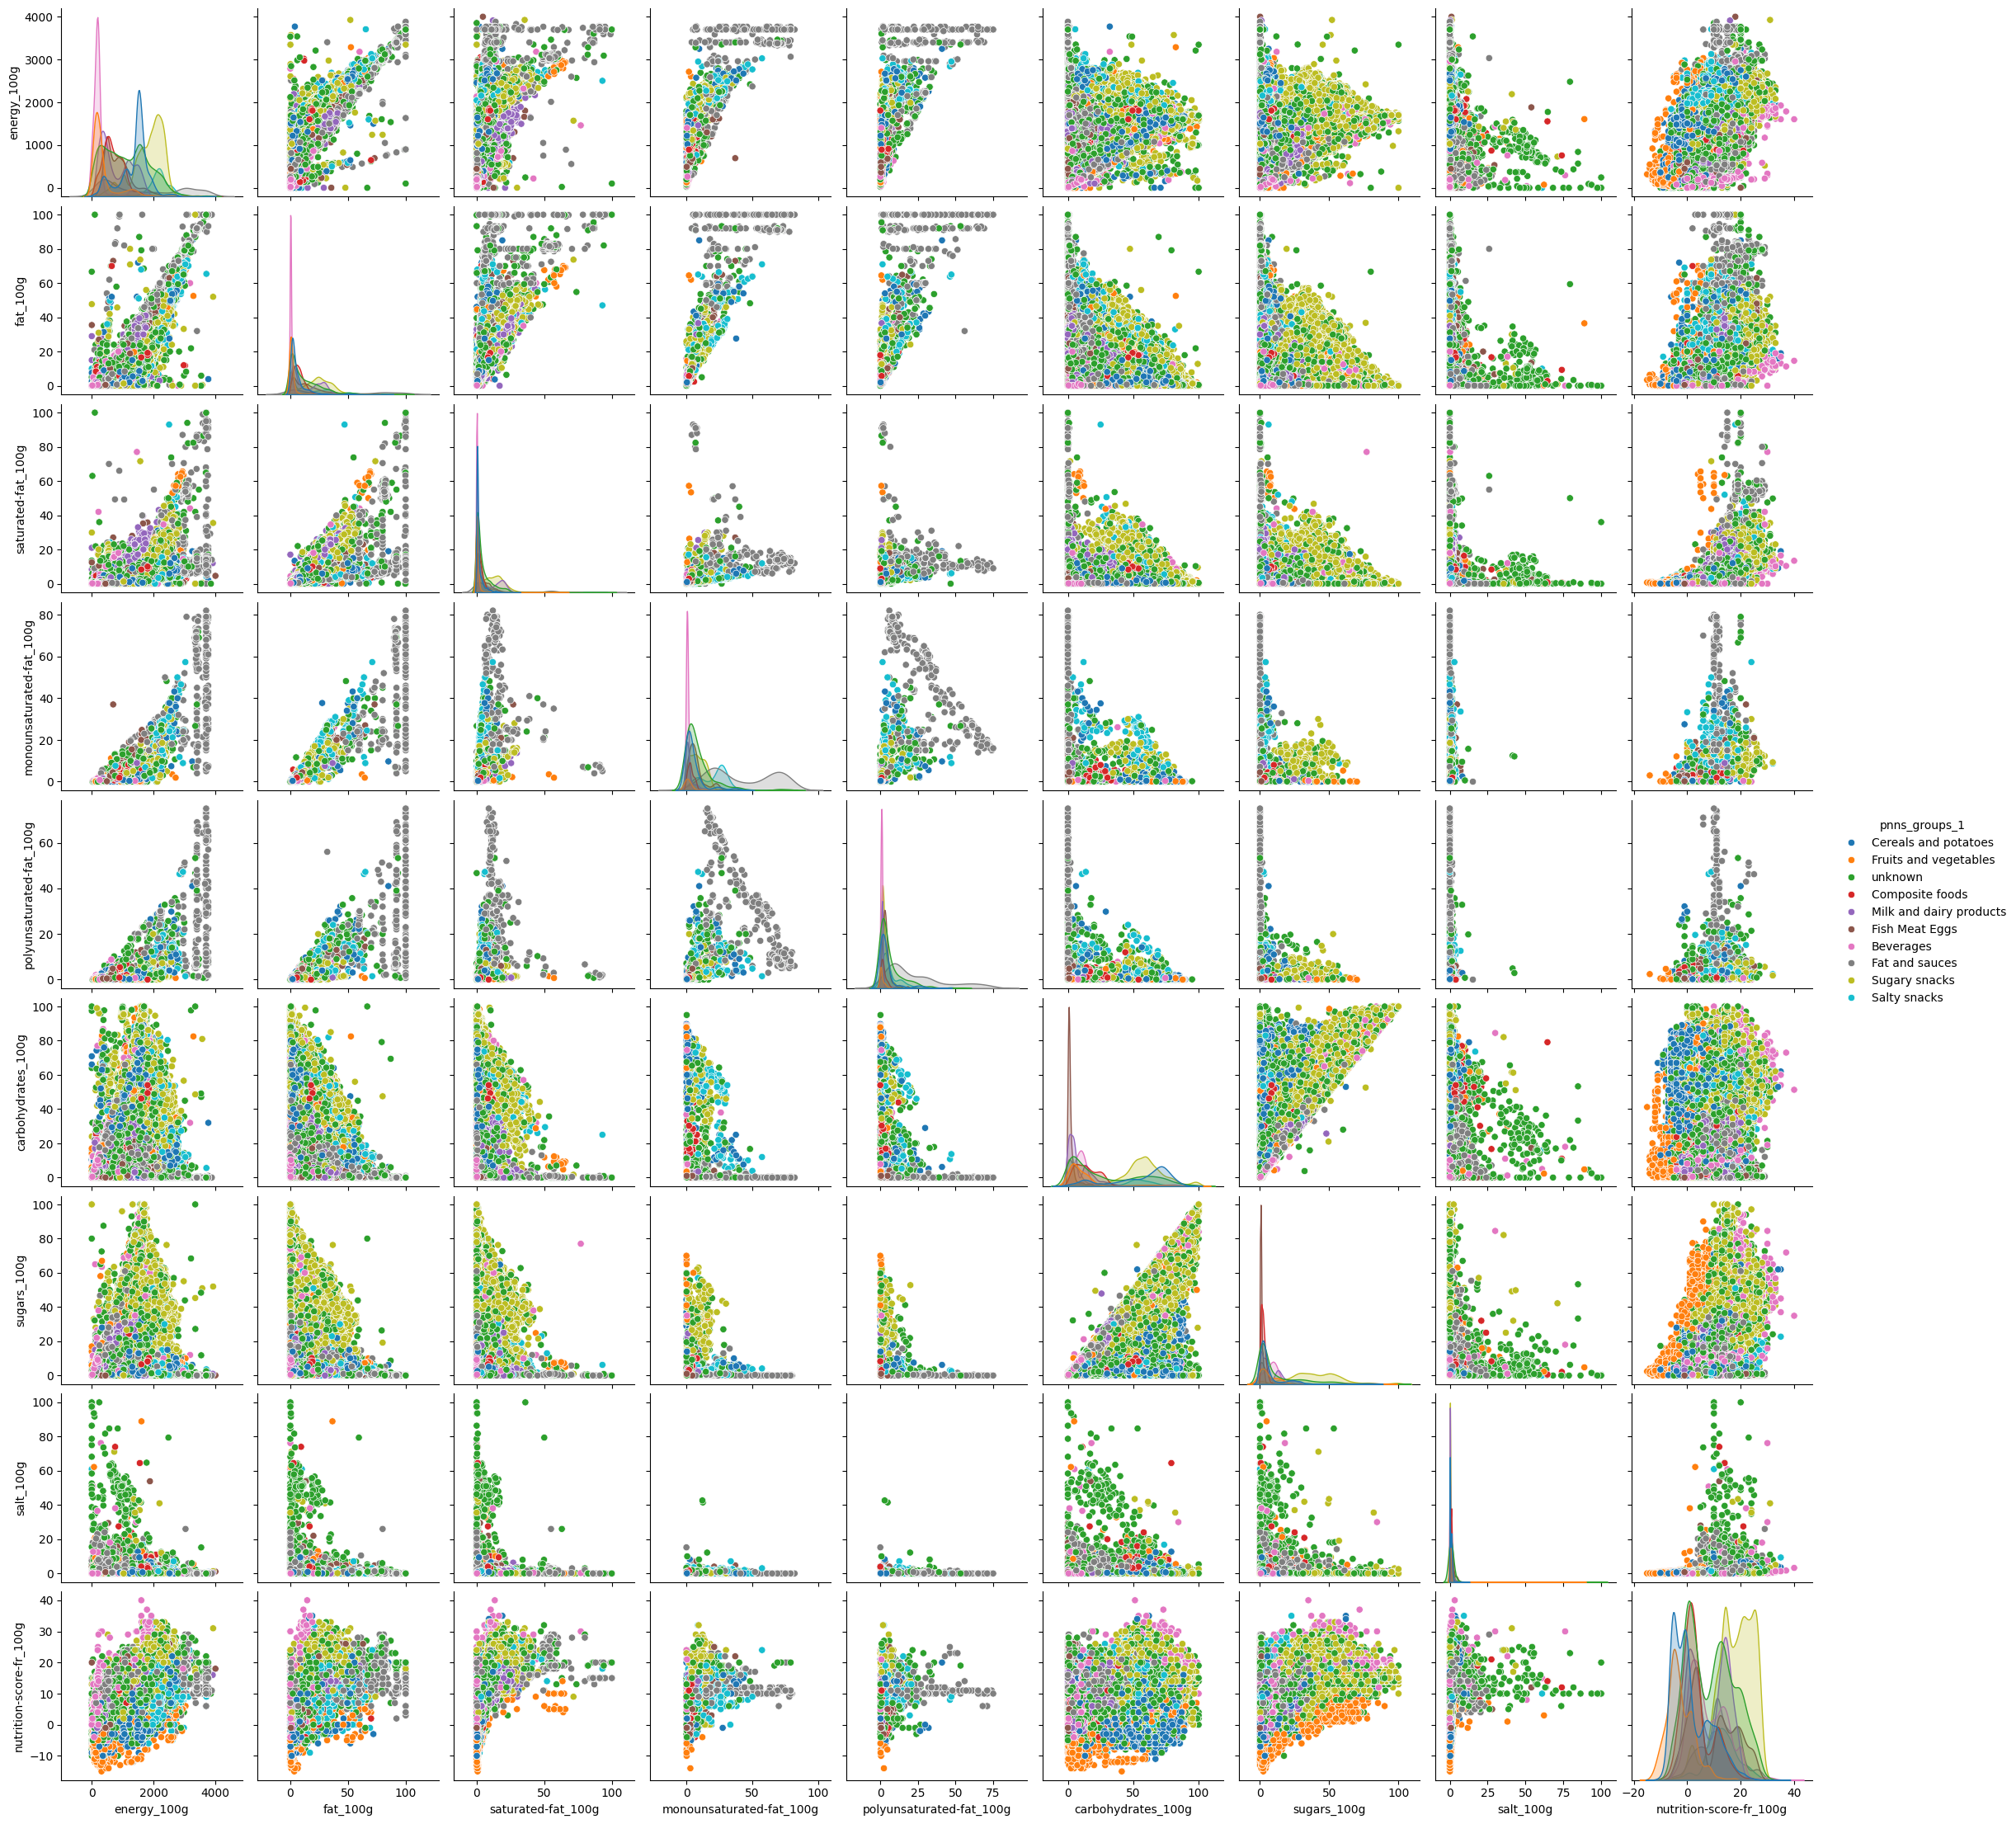

<Figure size 2463.38x2250 with 0 Axes>

In [122]:
variable=['energy_100g','fat_100g','saturated-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g','carbohydrates_100g','sugars_100g','salt_100g','nutrition-score-fr_100g','pnns_groups_1']
hue_order =nutriscore_order['pnns_groups_1']
data_quant_corr = data_clean[variable]
# Analyse mutivariée via la méthode pairplot
sns_plot = sns.pairplot(data_quant_corr, hue="pnns_groups_1",hue_order=hue_order)
sns_plot.savefig("pairplot.png")
plt.clf() # Clean pairplot figure
Image(filename='pairplot.png') # Création de l'image PNG

On retrouve les résultats de la matrice de corrélations.

En les traçant en fonction du pnns_groups_1, on voit que les légumes sont plus facilement localisés sur un nutriscore bas ainsi que des valeurs basses de sel, sucre, graisses...

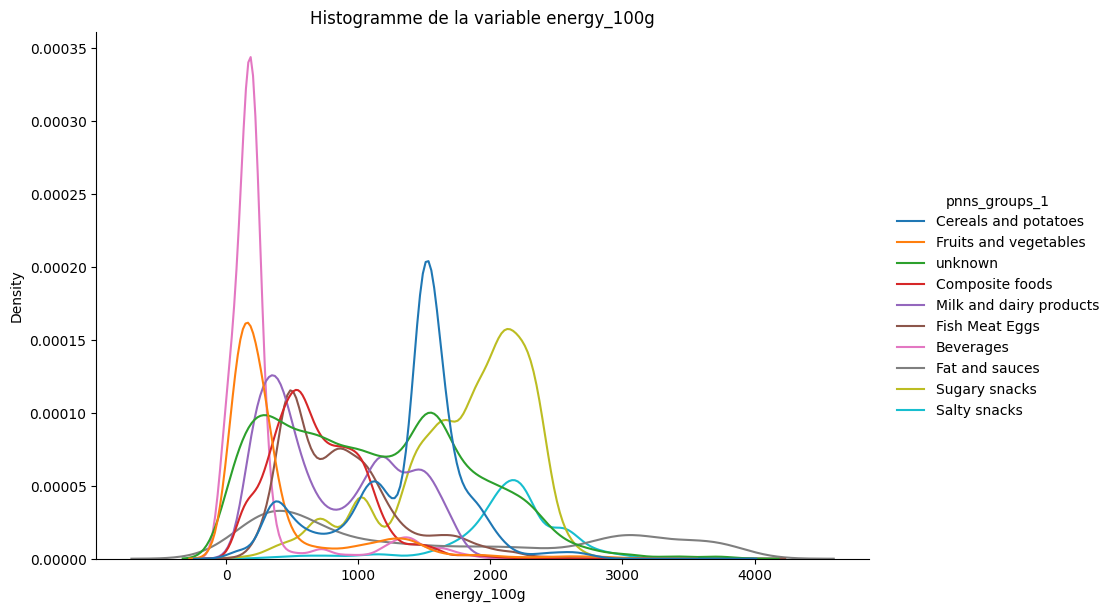

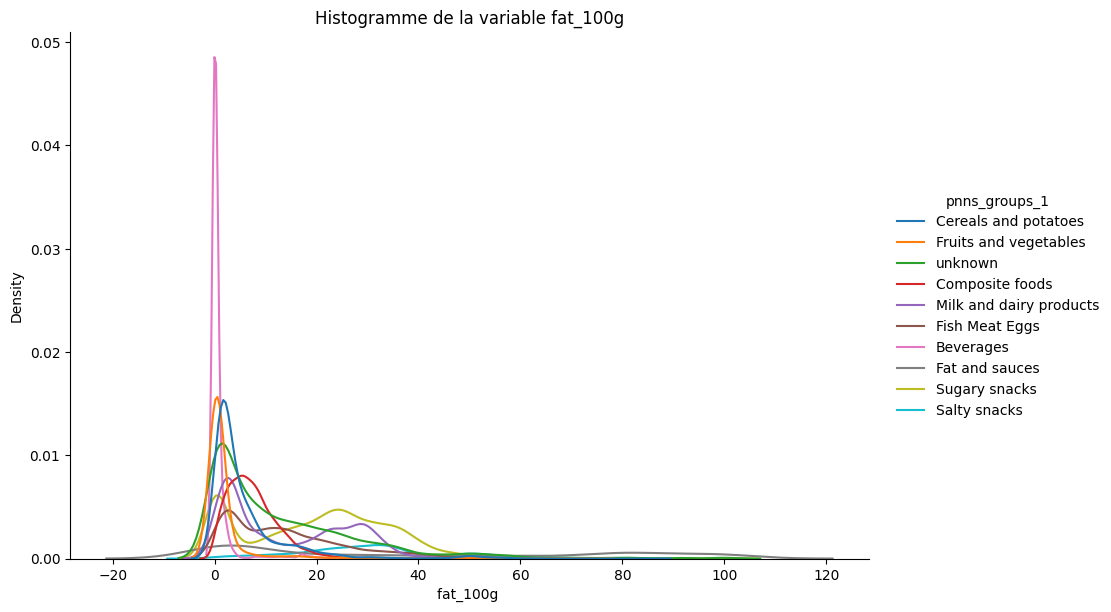

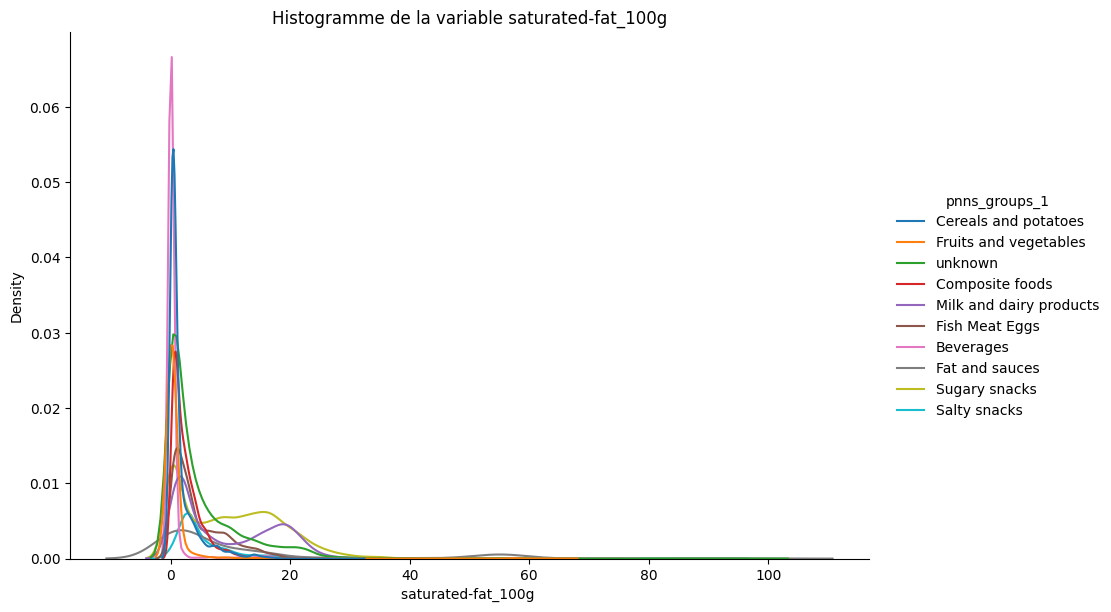

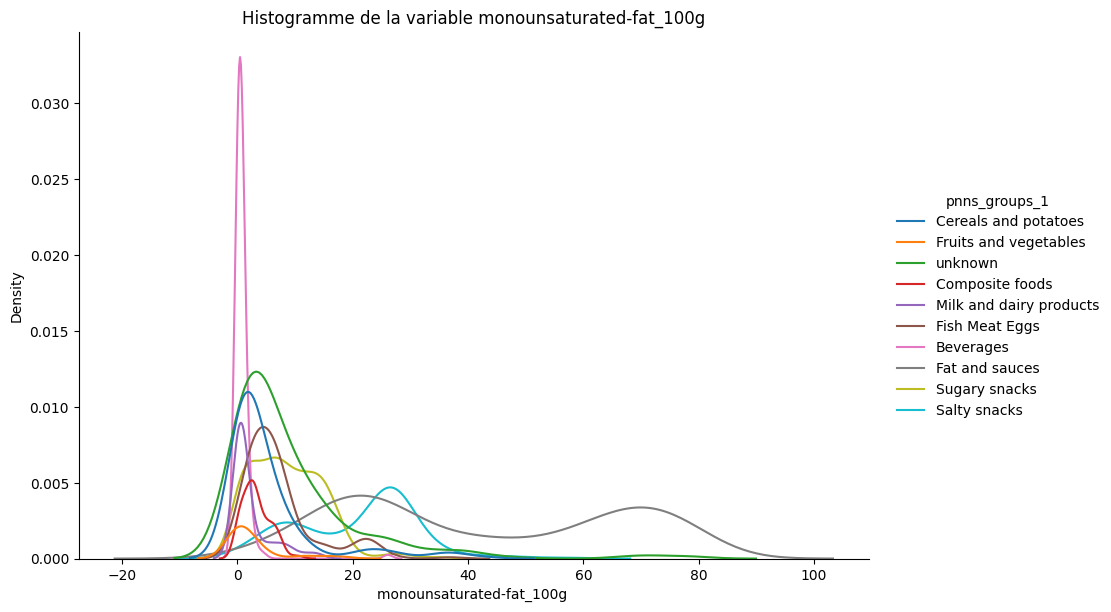

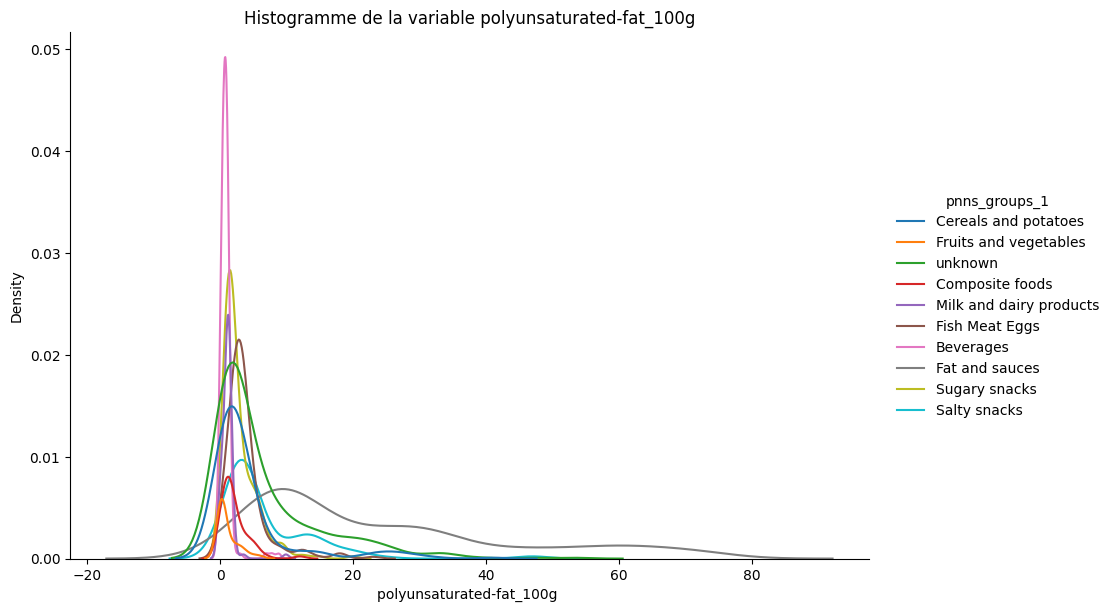

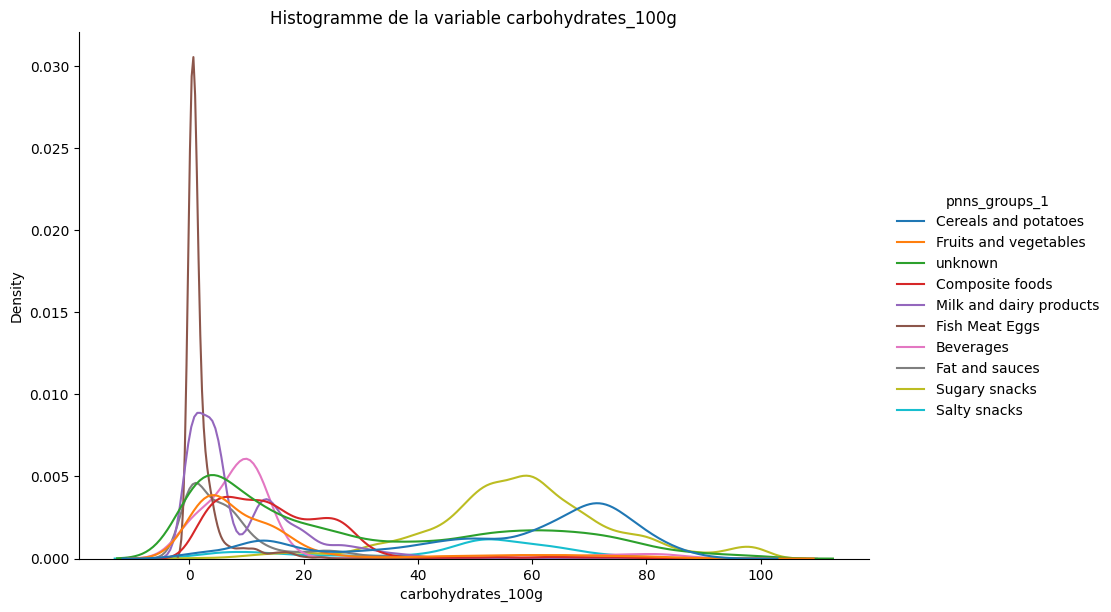

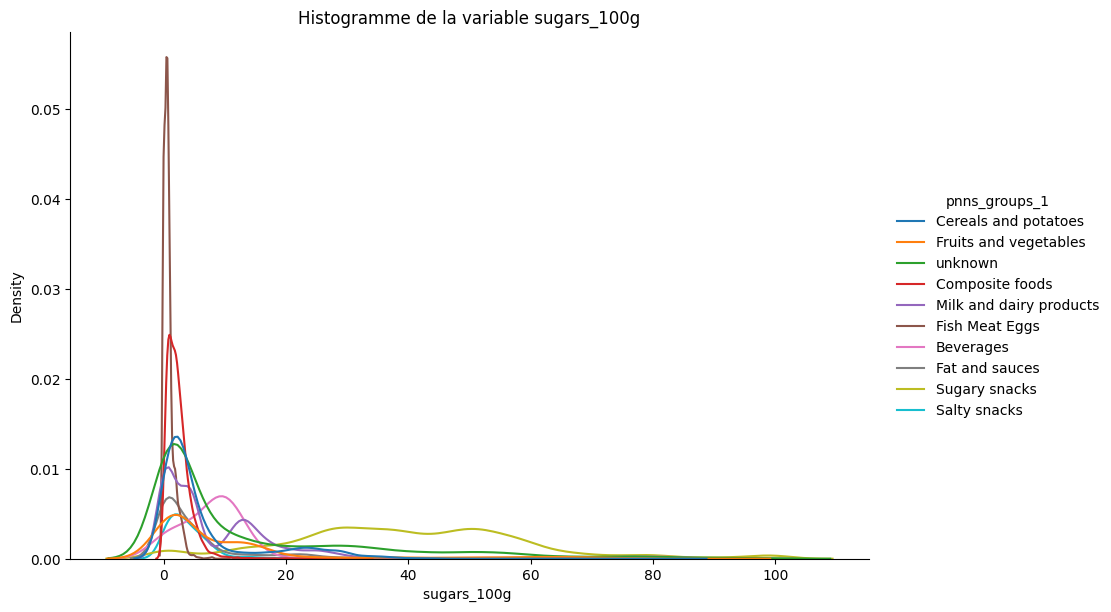

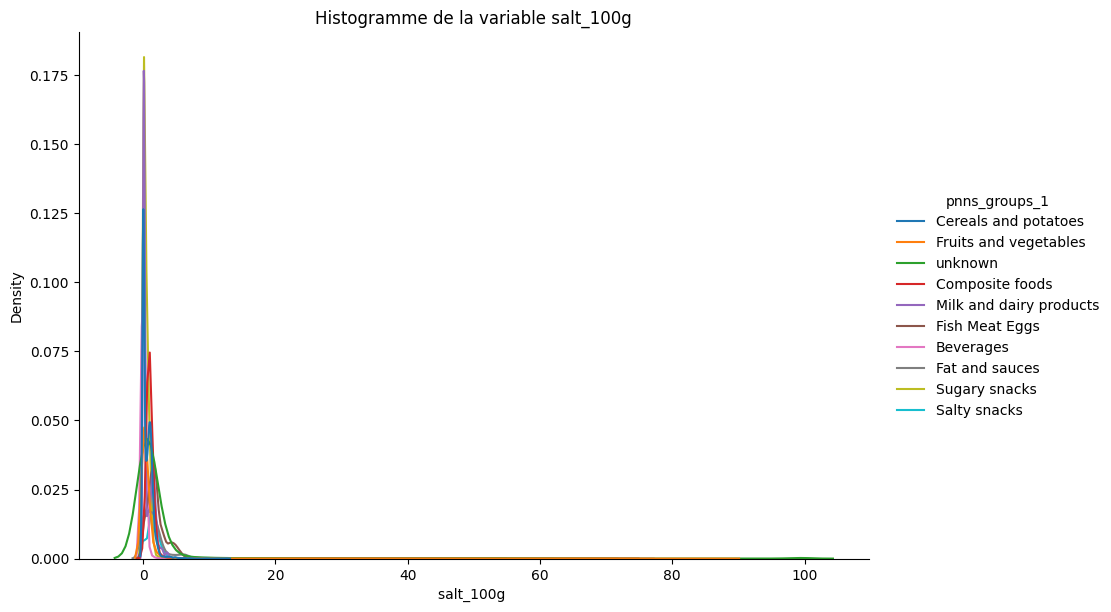

<Figure size 3000x3000 with 0 Axes>

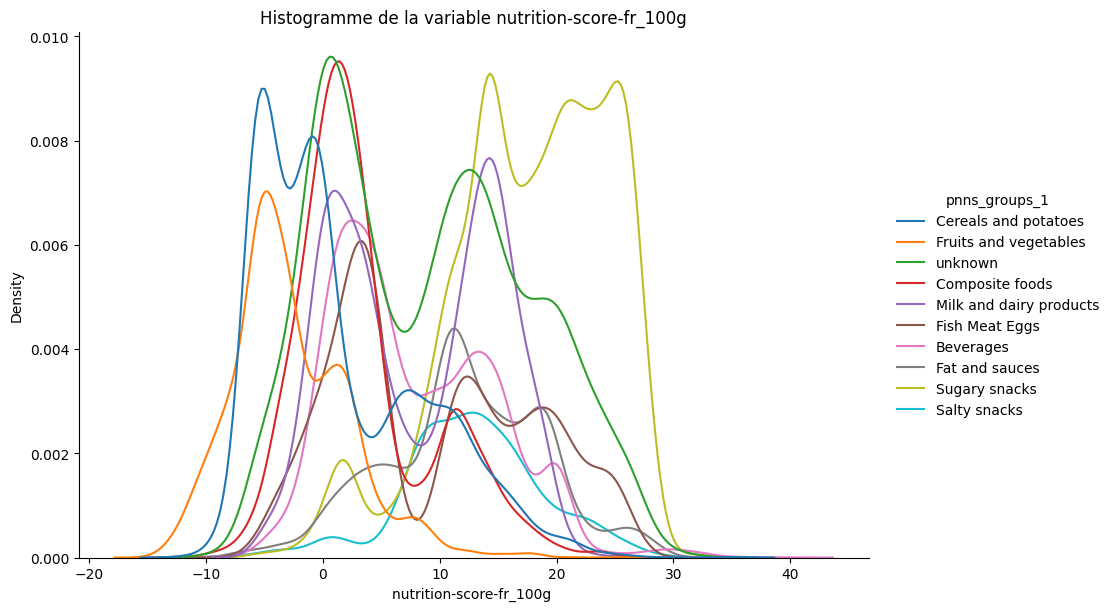

In [148]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',2),('saturated-fat_100g','green',3),('monounsaturated-fat_100g','forestgreen',4),('polyunsaturated-fat_100g','darkgreen',5),('carbohydrates_100g','red',6),('sugars_100g','black',7),('salt_100g','orange',8),('nutrition-score-fr_100g','purple',9)]
hue_order =nutriscore_order['pnns_groups_1']

# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(30, 30))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    sns.displot(data=data_clean, x=variable, hue="pnns_groups_1", kind="kde",  hue_order=hue_order,height=6, aspect=1.5) 
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")


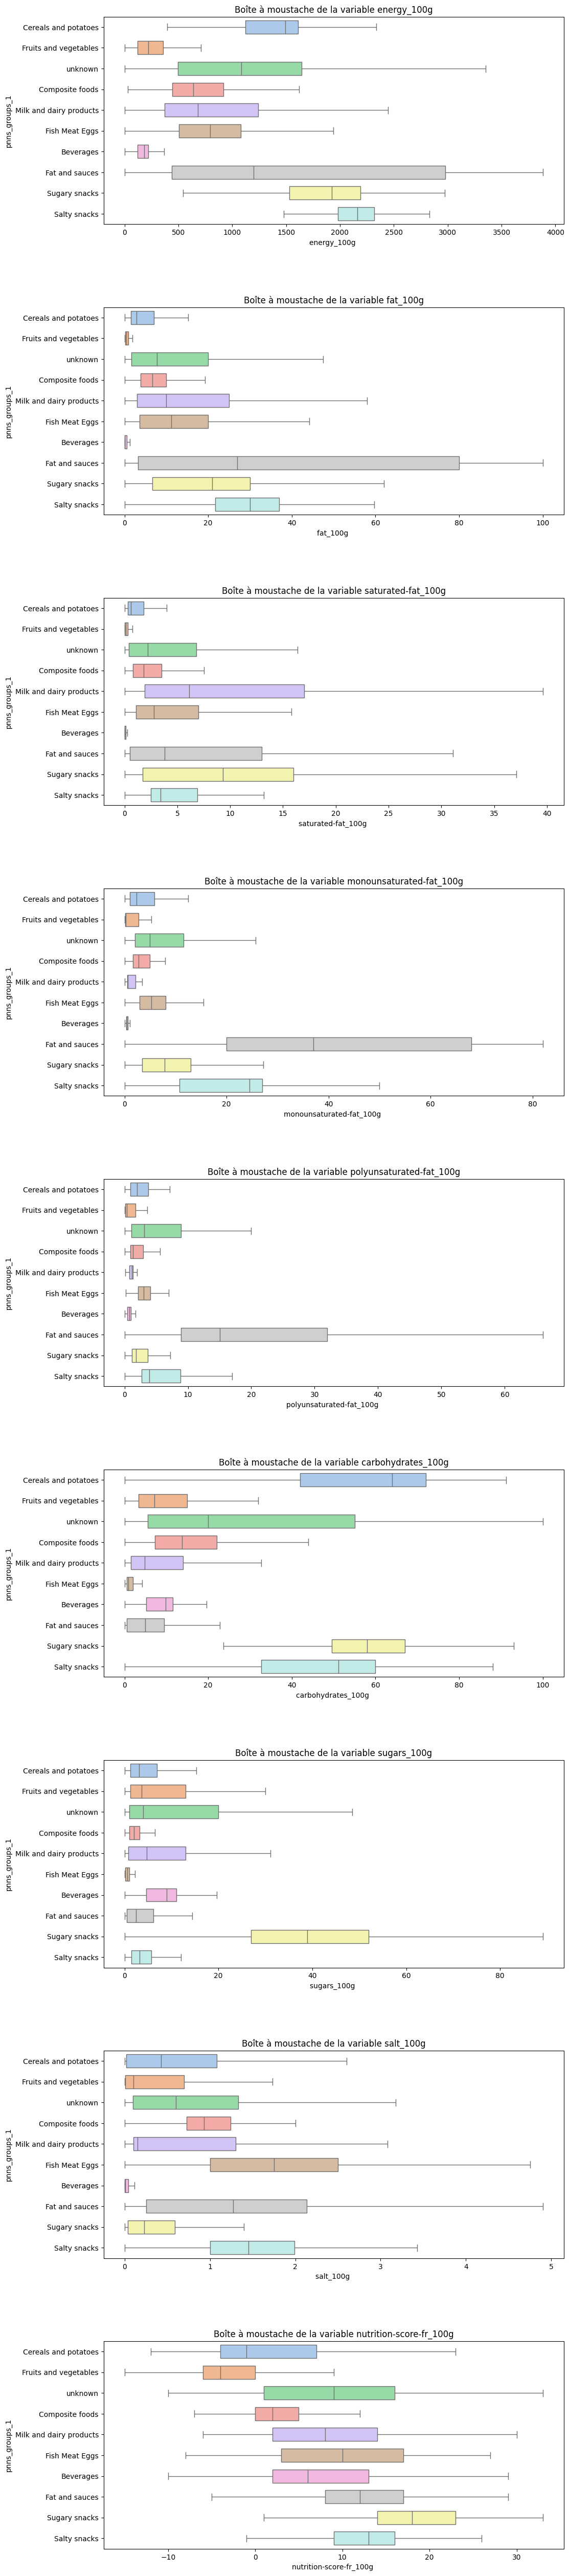

In [165]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',2),('saturated-fat_100g','green',3),('monounsaturated-fat_100g','forestgreen',4),('polyunsaturated-fat_100g','darkgreen',5),('carbohydrates_100g','red',6),('sugars_100g','black',7),('salt_100g','orange',8),('nutrition-score-fr_100g','purple',9)]
hue_order =nutriscore_order['pnns_groups_1']

# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10,10))
    plt.gcf().subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=5, hspace=0.4, wspace=0.3)

    # Création des boîtes à moustaches
    axes = figure.add_subplot(9, 1, place)
    sns.boxplot(data=data_clean,x=variable, y=data_clean["pnns_groups_1"], ax=axes, gap=0.2,legend=False,order=hue_order, showfliers=False, palette='pastel')
    plt.title(f'Boîte à moustache de la variable {variable}')
    plt.xlabel(f"{variable} ")

Comme pour les analyses univariées, on n'affichera pas les valeurs atypiques sur les boîtes à moustaches car les distributions des variables ne sont pas normales et donc la méthode interquartile n'est pas pertinente pour détecter les valeurs atypiques.

Il n'y a pas vraiment de surprises sur les résultats, on retrouve les catégories salées, sucrées et grasses avec des médianes de nutriscore les plus hauts, à l'opposé des fruits et légumes.

ANOVA sur pnns1 vs nutrition score

On s'interesse au variance de chaque groupe. Le test de Levene permet de tester si les variances sont significativement différentes ou non pour des variables qui n'ont pas de distribution normale (contrairement au test de Bartlett). 

In [46]:
# Test statistique de Levene pour valider ou infirmer l'homogénéisation de la variance entre les groupes

from scipy.stats import levene
xyz=[data_clean[data_clean['pnns_groups_1']=='Beverages']['nutrition-score-fr_100g'],data_clean[data_clean['pnns_groups_1']=='Cereals and potatoes']['nutrition-score-fr_100g'],
     data_clean[data_clean['pnns_groups_1']=='Composite foods']['nutrition-score-fr_100g'],data_clean[data_clean['pnns_groups_1']=='Fat and sauces']['nutrition-score-fr_100g'],
     data_clean[data_clean['pnns_groups_1']=='Fish Meat Eggs']['nutrition-score-fr_100g'],data_clean[data_clean['pnns_groups_1']=='Fruits and vegetables']['nutrition-score-fr_100g'],
     data_clean[data_clean['pnns_groups_1']=='Milk and dairy products']['nutrition-score-fr_100g'],data_clean[data_clean['pnns_groups_1']=='Salty snacks']['nutrition-score-fr_100g'],
     data_clean[data_clean['pnns_groups_1']=='Sugary snacks']['nutrition-score-fr_100g'],data_clean[data_clean['pnns_groups_1']=='unknown']['nutrition-score-fr_100g']]

test_stat, p_value = levene(xyz[0], xyz[1], xyz[2], xyz[3], xyz[4], xyz[5], xyz[6], xyz[7], xyz[8], xyz[9],nan_policy='omit')
print(test_stat, p_value)

582.3039934452152 0.0


Les résultats du test de Levene indique qu'il n'y a pas d'homogénéité de la variance entre les groupes (p-value <0.05 donc hypothèse de l'homogénéité de la variance rejetée) et qu'une ANOVA ne peut pas être réalisée tel quel. essayons de transformer les données en utilisant le logarithme.

In [64]:
from math import log
xyz_log=[]
l=len(xyz)
for i in range(0,l) :
    xyz_log.append(np.log(xyz[i]))
print(min(xyz_log[5]))
test_stat, p_value = levene(xyz_log[0], xyz_log[1], xyz_log[2], xyz_log[3], xyz_log[4], xyz_log[5], xyz_log[6], xyz_log[7], xyz_log[8], xyz_log[9],center='mean',nan_policy='omit')
print(test_stat, p_value)    SUREMENT PB AVEC - INFINI !!!!
    # faire le log sur chaque echantillon de xyz et refaire le test de leveene

-inf
nan nan


In [52]:
print(type(var_cat))

NameError: name 'var_cat' is not defined

In [62]:
liste_index=[]
for item in var_cat.index:
    liste_index.append(item)
print(liste_index)

NameError: name 'var_cat' is not defined

In [61]:
liste_var=[]
for item in var_cat:
    liste_var.append(item)
print(liste_var)

NameError: name 'var_cat' is not defined

In [195]:
dict={}
for i in range (0,10):
    dict[liste_index[i]]=liste_var[i]
print(dict)

{'Beverages': 46.41062999925393, 'Cereals and potatoes': 49.08032051695332, 'Composite foods': 32.77205780500089, 'Fat and sauces': 45.89201009563924, 'Fish Meat Eggs': 71.26069046907479, 'Fruits and vegetables': 24.67922529457183, 'Milk and dairy products': 46.18865397128191, 'Salty snacks': 36.41988938705102, 'Sugary snacks': 45.14613077365131, 'unknown': 75.72081631158858}


In [196]:
from scipy.stats import bartlett
bartlett(dict)

ValueError: Must enter at least two input sample vectors.


Sur les boites à moustaches, nous observons des valeurs atypiques pour la majorité de ces variables. 
Il semble difficile de pouvoir dire si ces valeurs atypiques sont aberrantes ou non sans être un expert et regarder chaque produit un par un.
Seules les valeurs atypiques liées au nutriscore et à l'énergie peuvent être étudiées :
- Les valeurs atypiques liées au nutriscore "e" semblent correctes car dans la méthode de calcul du nutriscore les boissons sont catégorisées "e" à partir d'un nutriscore de 10.
- Les valeurs atypiques liées au nutriscore "b" semblent correctes car dans la méthode de calcul du nutriscore les boissons sont catégorisées "b" à partir du minimum jusqu'à 2 (si ce n'est pas de l'eau).
-  Les valeurs atypiques basses liées au nutriscore "a" semblent correctes car dans la méthode de calcul du nutriscore les produits sont catégorisées "a" à partir du minimum jusqu'à atteindre les valeurs du nutriscore 'b'.
-  Les valeurs hautes liées au nutriscore 'a' sont cependant plus étonnantes car le nutriscore 'a' ne prend en compte que les valeurs égales ou inférieures à 0 et les boissons "eau".

In [30]:
# Vérification des valeurs atypiques égales à 10 pour le nutriscore e
x=data_clean.loc[(data_clean['nutrition-score-fr_100g']==10) & (data_clean['nutrition_grade_fr']=='e')]
x.head()

product_name nutrition_grade_fr  \
209                                    Iced Coffee                  e   
2356                                  Pass-o-Guava                  e   
2703            Coconut water with pineapple juice                  e   
2842                                         Pepsi                  e   
2925  Water extracted prune juice from concentrate                  e   

     pnns_groups_1        pnns_groups_2                   main_category_fr  \
209      Beverages  Sweetened beverages                           Boissons   
2356     Beverages         Fruit juices  Jus de fruits à base de concentré   
2703     Beverages  Sweetened beverages                           Boissons   
2842     Beverages  Sweetened beverages                              Sodas   
2925     Beverages         Fruit juices                      Jus de fruits   

      energy_100g  fat_100g  saturated-fat_100g  monounsaturated-fat_100g  \
209         139.0     0.152                 0.0                       NaN   
2356       1670.0     0.000                 0.0                       NaN   
2703        142.0     0.100                 0.1                       NaN   
2842         41.7     0.000                 0.0                       NaN   
2925        273.0     0.500                 0.1                       NaN   

      polyunsaturated-fat_100g  trans-fat_100g  carbohydrates_100g  \
209                        NaN             0.0                6.97   
2356                       NaN             0.0              100.00   
2703                       NaN             NaN                8.10   
2842                       NaN             NaN               11.40   
2925                       NaN             NaN               14.80   

      sugars_100g  proteins_100g  salt_100g  sodium_100g  \
209          6.36          0.303   0.015400      0.00606   
2356        84.00          0.000   0.203000      0.08000   
2703         7.50          0.200   0.100000      0.03937   
2842        11.40          0.000   0.021200      0.00833   
2925        14.80          0.500   0.029972      0.01180   

      nutrition-score-fr_100g  
209                      10.0  
2356                     10.0  
2703                     10.0  
2842                     10.0  
2925                     10.0

Ce sont bien des boissons donc les valeurs sont bien correctes

In [31]:
# Vérification des valeurs atypiques les plus basses pour le nutriscore b
x=data_clean.loc[(data_clean['nutrition-score-fr_100g']<0) & (data_clean['nutrition_grade_fr']=='b')]
x.head()

product_name nutrition_grade_fr pnns_groups_1  \
216             Strawberry Lemonade                  b     Beverages   
334               100% Tomato Juice                  b     Beverages   
562             Safeway apple juice                  b     Beverages   
563                 Vegetable juice                  b     Beverages   
1454  Original 100% Vegetable Juice                  b     Beverages   

              pnns_groups_2 main_category_fr  energy_100g  fat_100g  \
216            Fruit juices            Sodas        105.0       0.0   
334   Non-sugared beverages         Boissons         72.8       0.0   
562            Fruit juices     Jus de pomme          NaN       NaN   
563   Non-sugared beverages         Boissons          NaN       NaN   
1454  Non-sugared beverages         Boissons         86.2       0.0   

      saturated-fat_100g  monounsaturated-fat_100g  polyunsaturated-fat_100g  \
216                  0.0                       NaN                       NaN   
334                  0.0                       NaN                       NaN   
562                  NaN                       NaN                       NaN   
563                  NaN                       NaN                       NaN   
1454                 0.0                       NaN                       NaN   

      trans-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
216              0.0                7.50         5.56          0.000   
334              0.0                3.48         2.61          0.000   
562              NaN                 NaN          NaN            NaN   
563              NaN                 NaN          NaN            NaN   
1454             0.0                4.12         2.65          0.588   

      salt_100g  sodium_100g  nutrition-score-fr_100g  
216     0.00353      0.00139                     -2.0  
334     0.56700      0.22300                     -4.0  
562         NaN          NaN                    -10.0  
563         NaN          NaN                    -10.0  
1454    0.68700      0.27100                     -3.0

Ce sont bien des boissons donc les valeurs sont bien correctes

In [32]:
# Vérification des valeurs atypiques les plus hautes pour le nutriscore a
x=data_clean.loc[(data_clean['nutrition-score-fr_100g']>0) & (data_clean['nutrition_grade_fr']=='a')]
x.head()

product_name nutrition_grade_fr pnns_groups_1  \
8677   Pétillante saveur Citron                  a     Beverages   
15033            Volvic Limette                  a     Beverages   
15329       Sans sucres Agrumes                  a     Beverages   
15331                     Evian                  a     Beverages   
15338   La Salvetat Citron vert                  a     Beverages   

               pnns_groups_2 main_category_fr  energy_100g  fat_100g  \
8677   Non-sugared beverages             Eaux          1.0       0.0   
15033    Sweetened beverages             Eaux        205.0       0.0   
15329  Non-sugared beverages             Eaux          1.0       0.0   
15331  Non-sugared beverages             Eaux       2787.0       0.0   
15338  Non-sugared beverages             Eaux          3.0       0.0   

       saturated-fat_100g  monounsaturated-fat_100g  polyunsaturated-fat_100g  \
8677                  0.0                       NaN                       NaN   
15033                 0.0                       NaN                       NaN   
15329                 0.0                       NaN                       NaN   
15331                 0.0                       NaN                       NaN   
15338                 0.0                       NaN                       NaN   

       trans-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
8677              NaN                 0.0          0.0            0.0   
15033             NaN                 4.9         12.4            0.0   
15329             NaN                 0.0          0.0            0.0   
15331             NaN                 0.0          0.0            0.0   
15338             NaN                 0.0          0.0            0.0   

       salt_100g  sodium_100g  nutrition-score-fr_100g  
8677       0.007     0.002756                      1.0  
15033      0.010     0.003937                     16.0  
15329      0.010     0.003937                      1.0  
15331      0.000     0.000000                     10.0  
15338      0.010     0.003937                      1.0

Ce sont en effet des eaux , pétillantes ou non, aromatisées ou non. Le nutriscore 'a' n'est donné qu'aux eaux, peut-être que le fait qu'elles soient pétillantes ou aromatisées n'influe pas sur le nutriscore. Nous pouvons donc penser que ces valeurs sont cohérentes.

Regardonc la répartition du nutriscore dans notre base de données :

In [33]:
# Imputation à NaN de toutes les valeurs de nutriscore différentes de a,b,c,d ou e
nutri=['a','b','c','d','e']
data_clean.loc[~data_clean['nutrition_grade_fr'].isin(nutri)]='NaN'

C:\Users\celine.lesur\AppData\Local\Temp\ipykernel_27364\508296065.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_clean.loc[~data_clean['nutrition_grade_fr'].isin(nutri)]='NaN'


Text(0.5, 1.0, 'Proportion des nutriscores')

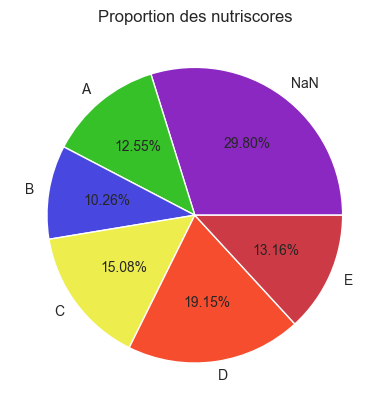

In [35]:
labels = ['NaN','A', 'B', 'C', 'D', 'E']
colors = ['#8b28c1','#36c128','#4848E1','#EDED4E','#F64D2F','#CC3B45']
sns.set_style("darkgrid")
# Affichage d'un diagramme circulaire pour visualiser la proportion des nutriscores dans notre base de données
plt.pie(x=data_nutri, labels=labels, colors=colors,autopct='%.2f%%')
plt.title("Proportion des nutriscores")


Il y a un nombre non négligeable de valeurs de nutrigrade manquants. Regardons si un nutriscore est renseigné afin de pouvoir l'imputer :

In [36]:
nutriscore_mv=data_clean.loc[(data_clean['nutrition-score-fr_100g'].isna()==False) & (data_clean['nutrition_grade_fr']=='Nan')]
nutriscore_mv.shape

(0, 17)

Aucun nutriscore n'est renseigné pour un nutrigrade manquant. L'imputation n'est donc pas évidente.

In [37]:
data_clean.describe()

product_name nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
count         85579              86267         86267         86267   
unique        50901                  6            11            41   
top             NaN                NaN           NaN           NaN   
freq          25501              25501         25501         25501   

       main_category_fr energy_100g fat_100g saturated-fat_100g  \
count             82146       86055    82748              86083   
unique             2020        3502     1411               1261   
top                 NaN         NaN      NaN                NaN   
freq              25501       25501    25501              25501   

       monounsaturated-fat_100g polyunsaturated-fat_100g trans-fat_100g  \
count                     27449                    27470          27211   
unique                      448                      397             67   
top                         NaN                      NaN            NaN   
freq                      25501                    25501          25501   

       carbohydrates_100g sugars_100g proteins_100g salt_100g sodium_100g  \
count               82684       86077         86084     86078       86082   
unique               1605        1576          1155      2775        2663   
top                   NaN         NaN           NaN       NaN         NaN   
freq                25501       25501         25501     25501       25501   

       nutrition-score-fr_100g  
count                    86267  
unique                      54  
top                        NaN  
freq                     25501

In [38]:
data_clean.loc[(data_clean['energy_100g']>4000), 'energy_100g']= np.nan

TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
hue_order = ['a', 'b', 'c','d','e']
colors={'a' : 'green', 'b':'blue', 'c':'yellow', 'd':'orange', 'e':'red'}

figure=plt.figure(1, figsize=(20, 10))
plt.gcf().subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.5, wspace=0.5, hspace=0.1)
    
    # # Création des histogrammes
plt.subplot(1, 2, 1)
sns.histplot(data=data_clean, x='energy_100g', color='yellow',kde=True,stat="density", hue="nutrition_grade_fr", palette=colors, hue_order=hue_order)
plt.title(f'Histogramme de la variable energy_100g')
plt.xlabel(f"energy_100g ")

    # Création des boîtes à moustaches
axes = figure.add_subplot(1, 2, 2)
sns.boxplot(data=data_clean,x='energy_100g', y=data_clean["nutrition_grade_fr"], ax=axes, palette=colors,gap=0.2,legend=False,order=["a", "b", "c", "d","e"])
plt.title(f'Boîte à moustache de la variable energy_100g')
plt.xlabel(f"energy_100g ")
plt.ylabel(f"Nutriscore")

La distribution semble plus proche de la réalité désormais. Même si des valeurs atypiques apparaissent encore sur le graphique des boites à moustaches, cela ne semble plus être des valeurs aberrantes

In [ ]:
data_clean=data_clean.drop(index=id_energy_max)
data_clean.describe()

In [ ]:
hue_order = ['a', 'b', 'c','d','e']
colors={'a' : 'green', 'b':'blue', 'c':'yellow', 'd':'orange', 'e':'red'}

figure=plt.figure(1, figsize=(20, 10))
plt.gcf().subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.5, wspace=0.5, hspace=0.1)
    
    # # Création des histogrammes
plt.subplot(1, 2, 1)
sns.histplot(data=data_clean, x='energy_100g', color='yellow',kde=True,stat="density", hue="nutrition_grade_fr", palette=colors, hue_order=hue_order)
plt.title(f'Histogramme de la variable energy_100g')
plt.xlabel(f"energy_100g ")

    # Création des boîtes à moustaches
axes = figure.add_subplot(1, 2, 2)
sns.boxplot(data=data_clean,x='energy_100g', y=data_clean["nutrition_grade_fr"], ax=axes, palette=colors,gap=0.2,legend=False,order=["a", "b", "c", "d","e"])
plt.title(f'Boîte à moustache de la variable energy_100g')
plt.xlabel(f"energy_100g ")
plt.ylabel(f"Nutriscore")

OUTLIER de l'energie???

In [ ]:
TEST STATISTIQUES ? ANOVA ? qualitative vs quantitative avec distribution normale  ou WILCOX ??

In [ ]:
 Nous allons donc enlever ces lignes pours lesquelles nous ne pouvons pas imputer le nutrigrade qui est un élément important de notre analyse.

In [ ]:
data_clean.drop(data_clean[data_clean['nutrition_grade_fr']=='NaN'].index, inplace=True)
data_clean.shape

Il nous reste 221210 produits dans notre base de données qui sont pertinentes pour l'analyse.

In [ ]:
data_nutri =data_clean.groupby('nutrition_grade_fr')['product_name'].count()

colors = sns.color_palette('bright')[0:6]
# Affichage d'un diagramme circulaire pour visualiser la proportion des nutriscores dans notre base de données
plt.pie(x=data_nutri, labels=['a','b','c','d','e'], colors=colors,autopct='%.2f%%')
plt.title("Proportion des nutriscores")

Quasiment les 2/3 des produits de notre base de données ont un nutriscore égal à C, D ou E. Seul 1/3 ont les meilleurs nutriscores A et B.

In [ ]:
#  Fonction permettant de supprimer les 7 premières colonnes ainsi que celles ayant un pourcentage de valeurs manquantes supérieur à l'entrée percent

def del_col_prod_and_miss_val(data,percent):  
    variables = []
    miss_val = []
    del_var=[]

    # Suppression des 7 premières colonnes 
    for item in data.columns[:7] :
        del_var.append(item)
    data=data.drop(columns=del_var, axis = 1)

    # Suppression des variables avec un pourcentage de valeurs manquantes supérieur à l'entrée percent
    del_var=[]
    for item in data.columns:
        variables.append(item)
        miss_val.append(data[item].isna().mean())

    output = pd.DataFrame({
        'variable': variables, 
        'miss_val': miss_val 
    })    
        
    del_output = output[output['miss_val']>=percent]
    for item in del_output['variable'] :
        del_var.append(item)
    output_afterdrop = data.drop(columns=del_var, axis = 1)
    return output_afterdrop


In [ ]:
# Fonction permettant de remplacer les valeurs manquantes d'une colonne par une deuxième et de supprimer la deuxième colonne
def rempl_missing_value(df,col1,col2) :
    variables = [col1, col2]
    df2=df[variables].isna()
    df_missing_name=df2.loc[(df2['product_name']==True) & (df2['generic_name']==False)]
    df_missing_name_index=df_missing_name.index.to_list()
    for i in df_missing_name_index :
        df.loc[i,col1] = df.loc[i,col2]    
    return df.drop([col2], axis=1)
            

In [ ]:
# On appelle la fonction pour créer un nouveau dataframe nettoyé 
data_clean = rempl_missing_value(data,'product_name','generic_name')


En ce qui concerne les informations nutritionnelles, il parait assez logique de mettre à 0 les valeurs manquantes en considérant que si cela n'a pas été rempli c'est que la valeur est nulle.

In [ ]:
# Imputation des valeur  Nan à 0 pour les informations nutritionnelles
data.iloc[:,63]


Liste des étapes:
- suggérer les valeurs manquantes pour une variable dont plus de 50% des valeurs sont manquantes.
- Repérer des variables pertinentes pour les traitements à venir, et nécessaires pour suggérer des valeurs manquantes,.
- Nettoyer les données en mettant en évidence les éventuelles valeurs manquantes parmi les variables pertinentes sélectionnées, avec au moins 3 méthodes de traitement adaptées aux variables concernées,
(imputation par 0, moyenne, médiane OU estimation avec ML de type KNN OU estimation via iterative imputer (pertinente que sur des variables corrélées entre elles)
- en identifiant et en traitant les éventuelles valeurs aberrantes de chaque variable.
- Automatiser ces traitements pour éviter de répéter ces opérations

- Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données et de les expliquer  à un public néophyte (attention à la lisibilité : taille des textes, choix des couleurs, netteté suffisante, et variez les graphiques (boxplots, histogrammes, diagrammes circulaires, nuages de points…)).
- Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement + graphiques variables catégorielles et numériques
- Effectuer une analyse bivariée avec matrice de corrélations + graphiques croisant 2 variables numériques OU une numérique et une catégorielle
- Sélectionner / créer des variables à l’aide d’une analyse multivariée. Analyse descriptive en Composante Principale (ACP) / Analyse explicative ANOVA
Effectuer les tests statistiques appropriés pour vérifier la significativité des résultats + graphiques (ex : repartition du nutriscore, nb d'articles vendus dans chaque pays,...)

- Rédiger un rapport d’exploration et une conclusion pour expliquer la faisabilité de l’application demandée.

- Même si les données n’incluent pas de données personnelles, on doit expliquer dans une présentation en quoi ce projet respecte les 5 grands principes du RGPD. Santé publique France aimerait publier quelque chose sur le site Open Food Facts pour couper court aux questions sur le respect des RGPD que nous recevons parfois. 